# Imports

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Linear algebra
import numpy as np
# Random
import random
# Dataframe manipulation
import pandas as pd

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# Scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, _LRScheduler
from transformers import get_cosine_schedule_with_warmup

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc # Import auc function
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score

# statistics
from scipy.stats import pearsonr
import scipy.stats as st

# Report training progress
import wandb
wandb.login(key="fb87cc95d8c69efe715ee816e61954c9776c372d")  # TODO: Don't publish the key

# Progress bar
from tqdm import tqdm

# File management
import os
from pathlib import Path
DATA_PATH = Path('/zdata/user-data/noam/data/p2cs')

# Running best model heap
import heapq

# Plotting
import matplotlib
import mpld3
mpld3.enable_notebook()
import matplotlib.pyplot as plt
import seaborn as sns
# pseudocolor scatter plot
from scipy.stats import gaussian_kde

# Counter
from collections import Counter

# time
import time

# garbage collector
import gc

# build graph structures
import networkx as nx

import builtins

# type hints
from typing import Tuple, Optional, List, Dict, Any

# hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# memory profiler
%load_ext memory_profiler

/zdata/user-data/noam/.conda/envs/python310/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /zdata/user-data/noam/.netrc
wandb: Currently logged in as: segalnoam to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
base_dir = Path("/zdata/user-data/noam/data/p2cs/")
full_genomes_dir = base_dir / "full_genomes_new"
organism_merged_genomes_dir = base_dir / "organism_merged_genomes_new"
genome_analysis_dir = base_dir / "genome_analysis_results"
mash_analysis_dir = base_dir / "mash_analysis"
data_dir = mash_analysis_dir / "distance_matrices"  # For genome-level matrices
taxonomy_dir = base_dir / "taxonomy"
experimental_validation_dir = base_dir / "experimental_validation"
marginal_specificity_dir = experimental_validation_dir / "marginal_specificity_paper"
k_values = [11, 15, 19, 21]

# Loss & Evaluation

In [4]:
def project_single_embedding(model, embedding, embedding_class, device, hk_vae=None):
    """
    Given a single numerical 1D numpy array: embedding,
    and a string embedding_class ("HK" or "RR"),
    project the embedding through the appropriate model head, returning the normalized latent representation.
    """
    model.eval()
    if hk_vae is not None:
        hk_vae.eval()

    emb_t = torch.tensor(embedding, dtype=torch.float32, device=device).unsqueeze(0)  # shape (1, D)

    with torch.no_grad():
        if hk_vae is not None and embedding_class == "HK":
            # Use VAE for HK
            mu, logvar = hk_vae.encode(emb_t)
            emb_t = mu  # Use the latent mean

        if embedding_class == "HK":
            out = model.hk_head(emb_t)[0]
        elif embedding_class == "RR":
            out = model.rr_head(emb_t)[0]
        else:
            raise ValueError(f"Unexpected embedding_class '{embedding_class}', expected 'HK' or 'RR'")

        emb_norm = F.normalize(out, p=2, dim=-1)
        output_emb = emb_norm.cpu().numpy()

    return output_emb


def project_single_head_embeddings(model, embeddings, embedding_class, device, hk_vae=None):
    """
    Given a 2D numpy array of embeddings with shape (N, D),
    project each embedding through the appropriate model head using the
    provided embedding_class ("HK" or "RR"), and return the normalized
    latent representations.
    """
    model.eval()
    if hk_vae is not None:
        hk_vae.eval()

    emb_t = torch.tensor(embeddings, dtype=torch.float32, device=device)

    with torch.no_grad():
        if hk_vae is not None and embedding_class == "HK":
            # Use VAE for HK embeddings and take the latent means
            mu, _ = hk_vae.encode(emb_t)
            emb_t = mu

        if embedding_class == "HK":
            out = model.hk_head(emb_t)
        elif embedding_class == "RR":
            out = model.rr_head(emb_t)
        else:
            raise ValueError(f"Unexpected embedding_class '{embedding_class}', expected 'HK' or 'RR'")

        emb_norm = F.normalize(out, p=2, dim=-1)
        output_emb = emb_norm.cpu().numpy()

    return output_emb


def coembed(model, dataloader, device, hk_vae=None):
    model.eval()
    if hk_vae is not None:
        hk_vae.eval()

    hk_emb_list, rr_emb_list, organism_list, hk_gene_list, rr_gene_list = [], [], [], [], []

    with torch.no_grad():
        for (hk_batch_data, rr_batch_data, organism_batch, hk_gene_batch, rr_gene_batch), _ in tqdm(dataloader, desc="Collecting Embeddings for Similarity Calculation"):
            hk_batch_data, rr_batch_data = hk_batch_data.to(device), rr_batch_data.to(device)

            # Pass HK data through VAE encoder if VAE is provided
            if hk_vae is not None:
                mu, logvar = hk_vae.encode(hk_batch_data)
                hk_input_for_adapter = mu
            else:
                hk_input_for_adapter = hk_batch_data

            hk_emb, rr_emb, temp, gamma = model(hk_input_for_adapter, rr_batch_data)

            hk_emb_list.append(hk_emb)
            rr_emb_list.append(rr_emb)
            organism_list.extend(organism_batch)
            hk_gene_list.extend(hk_gene_batch)
            rr_gene_list.extend(rr_gene_batch)

    # Concatenate embeddings into single tensors
    hk_norm = F.normalize(torch.cat(hk_emb_list, dim=0), p=2, dim=1)
    rr_norm = F.normalize(torch.cat(rr_emb_list, dim=0), p=2, dim=1)

    N = hk_norm.shape[0]
    device = hk_norm.device

    # Create organism mask - True where organisms match
    unique_organisms = list(set(organism_list))
    organism_to_id = {org: i for i, org in enumerate(unique_organisms)}
    organism_ids = torch.tensor([organism_to_id[org] for org in organism_list], device=device)
    org_equal_mask = (organism_ids[:, None] == organism_ids[None, :])

    # Create cognate mask (diagonal)
    cognate_mask = torch.eye(N, device=device, dtype=torch.bool)

    # Create promiscuity mask (repeated hks with different cognate rrs)
    hk_gene_counts = Counter(hk_gene_list)
    rr_gene_counts = Counter(rr_gene_list)
    promiscuity_mask = torch.zeros((N, N), device=device, dtype=torch.bool)
    for i in range(N):
        if hk_gene_counts[hk_gene_list[i]] > 1:
            # Find all indices in the full list that share this HK gene
            all_indices_of_this_hk = [j for j, gene in enumerate(hk_gene_list) if gene == hk_gene_list[i]]
            for k in all_indices_of_this_hk:
                 # Mark all pairs where HK i is matched with RR k (a cognate of one of the duplicated HKs)
                 promiscuity_mask[i, k] = True
        if rr_gene_counts[rr_gene_list[i]] > 1:
            # Find all indices in the full list that share this RR gene
            all_indices_of_this_rr = [j for j, gene in enumerate(rr_gene_list) if gene == rr_gene_list[i]]
            for k in all_indices_of_this_rr:
                # Mark all pairs where RR i is matched with HK k (a cognate of one of the duplicated RRs)
                promiscuity_mask[i, k] = True

    return hk_norm, rr_norm, cognate_mask, promiscuity_mask, org_equal_mask, organism_list


def soft_clip_loss(similarity_matrix, target_matrix, temperature=0.07, eps=1e-8):
    """
    Computes symmetric CLIP-style contrastive loss with soft target similarity.

    Args:
        similarity_matrix (Tensor): [N, N] cosine similarities (unnormalized).
        target_matrix (Tensor): [N, N] soft similarity targets (e.g., 1, 0.5, 0).
        temperature (float): Scaling factor applied to similarities.
        eps (float): Small value to prevent division by zero or log(0).

    Returns:
        loss (Tensor): Scalar loss value.
    """
    # Apply temperature scaling
    logits = similarity_matrix / temperature
    tgt_logits = target_matrix / temperature

    # Log-probs along rows and columns (image-to-text and text-to-image)
    log_probs_i2t = F.log_softmax(logits, dim=1)  # row-wise
    log_probs_t2i = F.log_softmax(logits, dim=0)  # column-wise

    # Normalize target matrix row-wise and column-wise to form soft distributions
    log_tgt_probs_i2t = F.log_softmax(tgt_logits, dim=1)
    log_tgt_probs_t2i = F.log_softmax(tgt_logits, dim=0)

    # Compute KL divergence in both directions
    loss_i2t = F.kl_div(log_probs_i2t, log_tgt_probs_i2t,
                        reduction='batchmean', log_target=True)
    loss_t2i = F.kl_div(log_probs_t2i, log_tgt_probs_t2i,
                        reduction='batchmean', log_target=True)

    return 0.5 * (loss_i2t + loss_t2i)


def organism_aware_clip_loss(hk_emb, rr_emb, organism, hk_genes, rr_genes, temperature, gamma, mask_inter_organism_loss=False):
    """Compute organism-aware CLIP loss with optional inter-organism loss masking.

    Args:
        hk_emb: HK embeddings
        rr_emb: RR embeddings  
        organism: List of organism names
        hk_genes: List of HK gene names
        rr_genes: List of RR gene names
        temperature: Temperature scaling factor
        gamma: Gamma parameter for inter-organism similarity
        mask_inter_organism_loss: If True, only intra-organism pairs contribute to loss
    """
    # Normalize embeddings
    hk_emb = F.normalize(hk_emb, dim=-1)
    rr_emb = F.normalize(rr_emb, dim=-1)

    batch_size = hk_emb.shape[0]
    device = hk_emb.device

    # Calculate similarity matrix
    similarity_matrix = hk_emb @ rr_emb.T  # shape (B, B), unnormalized

    # Create organism mask - True where organisms match
    organism_tensor = torch.tensor([hash(org)
                                   for org in organism], device=device)
    same_organism_mask = (
        organism_tensor[:, None] == organism_tensor[None, :])  # (B, B)

    # Create cognate mask (diagonal)
    cognate_mask = torch.eye(batch_size, device=device, dtype=torch.bool)

    # Identify duplicated HK genes and their cognates within the batch
    hk_gene_counts = Counter(hk_genes)
    rr_gene_counts = Counter(rr_genes)
    duplicated_hk_indices = [i for i, gene in enumerate(
        hk_genes) if hk_gene_counts[gene] > 1]
    duplicated_rr_indices = [i for i, gene in enumerate(
        rr_genes) if rr_gene_counts[gene] > 1]

    # Create a mask for duplicated HKs and their cognates
    duplicated_hk_mask = torch.zeros(
        (batch_size, batch_size), device=device, dtype=torch.bool)
    for i in duplicated_hk_indices:
        all_indices_of_this_hk = [j for j, gene in enumerate(
            hk_genes) if gene == hk_genes[i]]
        duplicated_hk_mask[i, all_indices_of_this_hk] = True

    # Create a mask for duplicated RR genes and their cognates
    duplicated_rr_mask = torch.zeros(
        (batch_size, batch_size), device=device, dtype=torch.bool)
    for i in duplicated_rr_indices:
        all_indices_of_this_rr = [j for j, gene in enumerate(
            rr_genes) if gene == rr_genes[i]]
        duplicated_rr_mask[i, all_indices_of_this_rr] = True

    # Construct the target similarity matrix ensuring gamma remains a tensor for gradient flow
    # Create a matrix of ones with the same shape as similarity_matrix
    target_matrix = torch.ones_like(similarity_matrix) * gamma

    # For same organism pairs, set target to 0 (unless they are cognates)
    target_matrix[same_organism_mask] = 0.0

    # For cognate pairs (including duplicated HK cognates), set target to 1
    cognate_pairs = cognate_mask | duplicated_hk_mask | duplicated_rr_mask  # TODO: reinstate
    target_matrix[cognate_pairs] = 1.0

    # Ensure targets are non-negative (should be handled by the logic above, but for safety)
    target_matrix = torch.relu(target_matrix)

    # Apply inter-organism loss masking if requested
    if mask_inter_organism_loss:
        # Create mask for intra-organism pairs only (same organism or cognates)
        intra_organism_mask = same_organism_mask | cognate_mask
        # Set inter-organism similarities to a neutral value to mask their contribution
        similarity_matrix = torch.where(
            intra_organism_mask, similarity_matrix, torch.zeros_like(similarity_matrix))
        target_matrix = torch.where(
            intra_organism_mask, target_matrix, torch.zeros_like(target_matrix))

    # Compute the soft contrastive loss using the helper function
    total_loss = soft_clip_loss(
        similarity_matrix, target_matrix, temperature=temperature)

    return total_loss


def evaluate_model(model, test_dataloader, device='cuda', gamma=0.5, hk_vae=None):
    model.eval()
    if hk_vae is not None:
        hk_vae.eval()
    total_test_loss = 0
    with torch.no_grad():
        for (hk_batch_data, rr_batch_data, organism, hk_genes, rr_genes), indices in tqdm(test_dataloader, desc="Evaluating on Test Set"):  # Unpack the tuple
            hk_batch_data, rr_batch_data = hk_batch_data.to(
                device), rr_batch_data.to(device)  # Move tensors to device
            # organism, hk_genes, and rr_genes are lists of strings/objects, don't move them to device like tensors

            # Pass HK data through VAE encoder if VAE is provided
            if hk_vae is not None:
                mu, logvar = hk_vae.encode(hk_batch_data)
                hk_input_for_adapter = mu  # Use the latent mean as input to the adapter
            else:
                hk_input_for_adapter = hk_batch_data  # Use original HK data

            hk_emb, rr_emb, temperature, gamma = model(
                hk_input_for_adapter, rr_batch_data)
            loss = organism_aware_clip_loss(
                hk_emb, rr_emb, organism, hk_genes, rr_genes, temperature, gamma)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_dataloader)
    return avg_test_loss


def evaluate_cognate_prediction(model, dataloader, device='cuda', restrict_organism=True, hk_vae=None):
    model.eval()
    if hk_vae is not None:
        hk_vae.eval()
    hk_embeddings = []
    rr_embeddings = []
    organism_list = []

    with torch.no_grad():
        for (hk_batch, rr_batch, organism, hk_genes, rr_genes), _ in tqdm(dataloader, desc="Generating Embeddings"):
            hk_batch, rr_batch = hk_batch.to(device), rr_batch.to(device)
            # organism, hk_genes, and rr_genes are lists of strings/objects, don't move them to device like tensors

            # Pass HK data through VAE encoder if VAE is provided
            if hk_vae is not None:
                mu, logvar = hk_vae.encode(hk_batch)
                hk_input_for_adapter = mu
            else:
                hk_input_for_adapter = hk_batch

            hk_emb, rr_emb, _, _ = model(hk_input_for_adapter, rr_batch)
            hk_embeddings.append(hk_emb)
            rr_embeddings.append(rr_emb)
            organism_list.extend(organism)

    # Stack embeddings on GPU
    hk_embeddings = torch.cat(hk_embeddings, dim=0)  # [N, D]
    rr_embeddings = torch.cat(rr_embeddings, dim=0)  # [N, D]

    # Normalize for cosine similarity
    hk_norm = F.normalize(hk_embeddings, p=2, dim=1)
    rr_norm = F.normalize(rr_embeddings, p=2, dim=1)

    # Compute cosine similarity matrix [N, N]
    similarity_matrix = torch.matmul(hk_norm, rr_norm.T)

    if restrict_organism:
        # Create a mask to restrict similarity comparison to same-organism RR embeddings
        organism_tensor = torch.tensor(
            [hash(o) for o in organism_list], device=device
        )  # hash to numeric for comparison

        # Compare outer product to get a mask [N, N] where True = same organism
        org_equal_mask = (organism_tensor[:, None] == organism_tensor[None, :])

        # Set similarity to -inf where organism does not match
        similarity_matrix[~org_equal_mask] = float('-inf')

    # Find nearest RR for each HK
    nearest_indices = torch.argmax(similarity_matrix, dim=1)

    # Ground truth: cognate should be at the same index
    ground_truth = torch.arange(len(hk_embeddings), device=device)

    accuracy = (nearest_indices == ground_truth).float().mean().item()
    return accuracy


def evaluate_cognate_prediction_topk(model=None, dataloader=None, device='cuda', k=None, threshold=None, restrict_organism=True, hk_embeddings=None, rr_embeddings=None, organism_list=None, hk_vae=None):
    """
    Fast TopK evaluation for the case where all HK-RR pairs are unique.
    Uses fully vectorized operations with no Python loops for maximum efficiency.

    This function assumes each HK protein appears exactly once in the dataset.

    Args:
        model: Trained model. Required if hk_embeddings and rr_embeddings are None.
        dataloader: DataLoader for evaluation. Used to get organism info if embeddings are not provided.
        device: Device to run inference on.
        k: Number of nearest neighbors to consider as cognates.
           If None, only thresholding is used.
        threshold: Similarity threshold. If None, only k-NN is used.
        restrict_organism: Whether to restrict comparisons to same organism.
        hk_embeddings (Tensor, optional): Pre-calculated HK embeddings.
        rr_embeddings (Tensor, optional): Pre-calculated RR embeddings.
        organism_list (list, optional): List of organisms corresponding to the embeddings.
                                       Required if embeddings are provided and dataloader is None.
        hk_vae (nn.Module, optional): The VAE model to encode HK embeddings before passing to the adapter.


    Returns:
        tuple: (TP, TN, FP, FN) confusion matrix values
    """
    if hk_vae is not None:
        hk_vae.eval()

    if hk_embeddings is None or rr_embeddings is None:
        if model is None or dataloader is None:
            raise ValueError("Either provide pre-calculated embeddings and organism_list, or a model and dataloader.")

        model.eval()
        hk_embeddings = []
        rr_embeddings = []
        organism_list = []

        with torch.no_grad():
            for (hk_batch, rr_batch, organism, hk_gene, rr_gene), _ in tqdm(dataloader, desc="Generating Embeddings for Evaluation"):
                hk_batch, rr_batch = hk_batch.to(device), rr_batch.to(device)

                # Pass HK data through VAE encoder if VAE is provided
                if hk_vae is not None:
                    mu, logvar = hk_vae.encode(hk_batch)
                    hk_input_for_adapter = mu
                else:
                    hk_input_for_adapter = hk_batch


                hk_emb, rr_emb, _, _ = model(hk_input_for_adapter, rr_batch)
                hk_embeddings.append(hk_emb)
                rr_embeddings.append(rr_emb)
                organism_list.extend(organism)

        # Stack embeddings on GPU
        hk_embeddings = torch.cat(hk_embeddings, dim=0)  # [N, D]
        rr_embeddings = torch.cat(rr_embeddings, dim=0)  # [N, D]
    else:
         # Ensure provided embeddings are on the correct device
        hk_embeddings = hk_embeddings.to(device)
        rr_embeddings = rr_embeddings.to(device)
        # If embeddings are provided, we need the organism list.
        # If dataloader is provided, we get it from there.
        # If dataloader is NOT provided, organism_list must be provided explicitly.
        if dataloader is not None:
             organism_list = []
             for (hk_batch, rr_batch, organism, hk_gene, rr_gene), _ in dataloader:
                 organism_list.extend(organism)
        elif organism_list is None:
             raise ValueError("organism_list must be provided when using pre-calculated embeddings and dataloader is None.")


    N = len(hk_embeddings)

    # Normalize for cosine similarity
    hk_norm = F.normalize(hk_embeddings, p=2, dim=1)
    rr_norm = F.normalize(rr_embeddings, p=2, dim=1)

    # Compute similarity matrix [N, N]
    similarity_matrix = torch.matmul(hk_norm, rr_norm.T)

    if restrict_organism:
        # Create organism mask - True where organisms match
        organism_tensor = torch.tensor([hash(o) for o in organism_list], device=device, dtype=torch.long)
        same_organism_mask = (organism_tensor[:, None] == organism_tensor[None, :])  # [N, N]

        # Set similarity to -inf where organism does not match
        similarity_matrix[~same_organism_mask] = float('-inf')
    else:
        # If not restricting by organism, all pairs are considered
        same_organism_mask = torch.ones(N, N, dtype=torch.bool, device=device) # Used for evaluation mask

    # Create prediction matrix: [N, N] where entry [i,j] is True if HK i predicts RR j as cognate
    prediction_matrix = torch.zeros(N, N, dtype=torch.bool, device=device)

    # Determine prediction indices based on threshold and k
    if threshold is not None:
        # Apply threshold first
        threshold_mask = (similarity_matrix >= threshold)

        if k is not None:
            # Combine thresholding with k-NN
            # Get top k indices for each HK
            _, top_k_indices = torch.topk(similarity_matrix, k=min(k, N), dim=1)  # [N, k]

            # Create a mask for the top k indices
            top_k_mask = torch.zeros(N, N, dtype=torch.bool, device=device)
            hk_indices_expand = torch.arange(N, device=device)[:, None].expand(-1, k)
            top_k_mask[hk_indices_expand.flatten(), top_k_indices.flatten()] = True

            # Final prediction mask: all above threshold OR among top k
            prediction_matrix = threshold_mask | top_k_mask
        else:
            # Only thresholding is used
            prediction_matrix = threshold_mask
    elif k is not None:
        # Only k-NN is used
        _, top_k_indices = torch.topk(similarity_matrix, k=min(k, N), dim=1)  # [N, k]
        hk_indices_expand = torch.arange(N, device=device)[:, None].expand(-1, k)
        prediction_matrix[hk_indices_expand.flatten(), top_k_indices.flatten()] = True
    else:
        # No k or threshold specified, default to k=1 (nearest neighbor)
        print("Warning: Neither k nor threshold specified. Defaulting to k=1.")
        _, top_k_indices = torch.topk(similarity_matrix, k=1, dim=1)  # [N, 1]
        hk_indices_expand = torch.arange(N, device=device)[:, None].expand(-1, 1)
        prediction_matrix[hk_indices_expand.flatten(), top_k_indices.flatten()] = True


    # Ground truth matrix: [N, N] where entry [i,j] is True if HK i and RR j are true cognates
    # In this case, true cognates are on the diagonal (same index)
    ground_truth_matrix = torch.eye(N, dtype=torch.bool, device=device)

    if restrict_organism:
        # Only consider same-organism pairs for evaluation
        evaluation_mask = same_organism_mask
    else:
        # Consider all pairs
        evaluation_mask = torch.ones(N, N, dtype=torch.bool, device=device)

    # Apply evaluation mask
    pred_masked = prediction_matrix[evaluation_mask]
    truth_masked = ground_truth_matrix[evaluation_mask]

    # Calculate confusion matrix - FULLY VECTORIZED
    TP = torch.sum(truth_masked & pred_masked).item()
    FN = torch.sum(truth_masked & ~pred_masked).item()
    FP = torch.sum(~truth_masked & pred_masked).item()
    TN = torch.sum(~truth_masked & ~pred_masked).item()

    return TP, TN, FP, FN


def adversary_loss_excluding_diagonal(predicted_distances, ground_truth_distances):
    """Calculate BCE loss with logits excluding diagonal elements, with flipped binary labels and predictions."""
    # Create mask to exclude diagonal elements
    n = predicted_distances.shape[0]
    mask = torch.ones_like(predicted_distances, dtype=torch.bool)
    mask.fill_diagonal_(False)  # Set diagonal to False

    # Apply mask (not flattened)
    pred_masked = predicted_distances[mask]
    gt_masked = ground_truth_distances[mask]
    
    # If ground truth is not float (boolean or int), ensure it's float for BCE loss
    gt_masked = gt_masked.float()

    # Calculate BCE loss with logits on non-diagonal elements with class balancing
    pos_weight = (gt_masked == 0).sum() / (gt_masked == 1).sum()
    return F.binary_cross_entropy_with_logits(pred_masked, gt_masked, pos_weight=pos_weight)


def evaluate_adversary_on_same_organism_prediction(predicted_organism_distances, ground_truth_organism_distances):
    """
    Evaluates the AUC of predicting 'same organism' vs 'different organism'
    using a provided organism distance matrix.

    Args:
        predicted_organism_distances (torch.Tensor): [N, N] matrix of predicted distances between organisms.
        ground_truth_organism_distances (torch.Tensor): [N, N] binary matrix where True (or 1) indicates same organism, False (or 0) different organism.

    Returns:
        tuple: (auc (float), negative_pair_ratio (float)) where:
            - auc: ROC-AUC score for 'same organism' vs 'different organism' prediction, treating lower distance as higher probability of "same organism".
            - negative_pair_ratio: Ratio of negative example pairs (different organisms) to total pairs in the sub-batch.
    """
    # If ground_truth_organism_distances is float, treat >0.5 as different, <=0.5 as same
    if ground_truth_organism_distances.dtype != torch.bool:
        y_true = (ground_truth_organism_distances <= 0.5)
    else:
        y_true = ground_truth_organism_distances

    # Flatten both arrays
    y_true_np = y_true.cpu().numpy().astype(np.uint8).flatten()
    # To assign higher scores to "same organism", we use negative distances (lower distance = higher score)
    y_score = (-predicted_organism_distances).detach().cpu().numpy().flatten()

    # Remove NaNs or Infs if present
    valid = np.isfinite(y_score)
    y_score = y_score[valid]
    y_true_np = y_true_np[valid]

    # Edge case: if there's only one class present, roc_auc_score will error
    if len(np.unique(y_true_np)) < 2:
        auc = float('nan')
    else:
        auc = roc_auc_score(y_true_np, y_score)

    # Calculate negative pair ratio (different organisms / total pairs)
    total_pairs = y_true_np.shape[0]
    negative_pairs = np.sum(y_true_np == 0)
    negative_pair_ratio = negative_pairs / total_pairs if total_pairs > 0 else 0.0

    return auc, negative_pair_ratio


def build_distance_matrix(organisms, distance_mat_df):
    """
    Construct a distance matrix for a batch of organisms.

    Args:
        organisms (list of str): List of organism names (batch).
        distance_mat_df (pd.DataFrame): Square DataFrame representing pairwise distances
            between organism names (must have organism names as both index and columns).
            If None, builds a binary same/different-organism matrix.

    Returns:
        torch.Tensor: 2D tensor of shape [batch_size, batch_size] where
            entry (i, j) is the phylogenetic distance between organisms[i] and organisms[j],
            or 0.0 if the same organism, or 1.0 for missing/different values.
    """
    if distance_mat_df is not None:
        # Subselect rows and columns corresponding to the input organisms with underscores
        sub_df = distance_mat_df.reindex(index=organisms, columns=organisms)

        # Set distance for same organism pairs to 0.0
        np.fill_diagonal(sub_df.values, 0.0)

        # Replace missing or NaN values with 1.0 (default max distance)
        distance_np = sub_df.fillna(1.0).to_numpy(dtype=np.float32)

        return torch.from_numpy(distance_np)
    else:
        # Create binary same-organism mask: 0 if same organism, 1 if different
        return build_same_organism_mask(organisms)


def build_same_organism_mask(organism_list):
    """Build binary mask where 0 indicates same organism, 1 indicates different organism."""
    n = len(organism_list)

    # Create mask using numpy for string comparison, then convert to tensor
    import numpy as np

    # Convert to numpy array for vectorized string comparison
    organisms = np.array(organism_list)

    # Create broadcasting comparison: organisms[i] != organisms[j] for all i,j
    # Shape: (n, 1) != (1, n) -> (n, n)
    mask_np = (organisms[:, np.newaxis] !=
               organisms[np.newaxis, :]).astype(np.float32)

    # Convert back to torch tensor with correct dtype
    return torch.from_numpy(mask_np).float()


def evaluate_adversary_accuracy(adversary, main_model, dataloader, device='cuda', hk_vae=None, distance_mat_df=None):
    """
    Evaluate adversary accuracy on same organism prediction across the entire dataset.

    Args:
        adversary: The phylogenetic adversary model
        main_model: The main DualHeadAdapter model to generate embeddings
        dataloader: DataLoader containing batches of (hk_batch, rr_batch, organism, hk_genes, rr_genes)
        device: Device to run evaluation on
        hk_vae: Optional VAE model for HK preprocessing
        distance_mat_df: Optional distance matrix DataFrame for ground truth distances

    Returns:
        tuple: (accuracy (float), negative_pair_ratio (float)) where:
            - accuracy: Overall accuracy of same organism prediction
            - negative_pair_ratio: Average ratio of negative example pairs across all batches
    """
    adversary.eval()
    main_model.eval()
    if hk_vae is not None:
        hk_vae.eval()

    total_accuracy = 0.0
    total_negative_ratio = 0.0
    batch_count = 0

    with torch.no_grad():
        for (hk_batch, rr_batch, organism, hk_genes, rr_genes), _ in tqdm(dataloader, desc="Evaluating Adversary Accuracy"):
            hk_batch, rr_batch = hk_batch.to(device), rr_batch.to(device)

            # Pass HK data through VAE encoder if VAE is provided
            if hk_vae is not None:
                mu, logvar = hk_vae.encode(hk_batch)
                hk_input_for_adapter = mu
            else:
                hk_input_for_adapter = hk_batch

            # Get embeddings from the main model
            hk_emb, rr_emb, _, _ = main_model(hk_input_for_adapter, rr_batch)

            batch_size = hk_batch.shape[0]

            # Get ground truth organism distances
            ground_truth_distances = build_distance_matrix(
                organism, distance_mat_df).to(device)

            # Predict pairwise distances using adversary
            pred_hk = hk_emb.unsqueeze(1).expand(-1, batch_size, -1)
            pred_rr = rr_emb.unsqueeze(0).expand(batch_size, -1, -1)
            predicted_distances = adversary(pred_hk, pred_rr).squeeze(-1)

            if predicted_distances.dim() == 3:
                predicted_distances = predicted_distances.squeeze(-1)

            # Evaluate accuracy for this batch
            batch_accuracy, batch_negative_ratio = evaluate_adversary_on_same_organism_prediction(
                predicted_distances, ground_truth_distances
            )

            total_accuracy += batch_accuracy
            total_negative_ratio += batch_negative_ratio
            batch_count += 1

    # Return average accuracy and negative pair ratio across all batches
    avg_accuracy = total_accuracy / batch_count if batch_count > 0 else 0.0
    avg_negative_ratio = total_negative_ratio / \
        batch_count if batch_count > 0 else 0.0
    return avg_accuracy, avg_negative_ratio


# Dataset Class

In [5]:
class CognateDataset(Dataset):
    def __init__(self, hk_embeddings, rr_embeddings, organisms=None, indices=None, hk_genes=None, rr_genes=None):
        self.hk = torch.tensor(hk_embeddings, dtype=torch.float32)
        self.rr = torch.tensor(rr_embeddings, dtype=torch.float32)
        self.organisms = np.array(organisms)  # Store organism information
        self.indices = np.array(indices) # Store the original indices
        self.hk_genes = np.array(hk_genes) # Store HK gene information
        self.rr_genes = np.array(rr_genes) # Store RR gene information
        assert len(self.hk) == len(self.rr)
        if organisms is not None:
            assert len(self.hk) == len(self.organisms)
        if indices is not None:
            assert len(self.hk) == len(self.indices)
        if hk_genes is not None:
            assert len(self.hk) == len(self.hk_genes)
        if rr_genes is not None:
            assert len(self.rr) == len(self.rr_genes)

    def __len__(self):
        return len(self.hk)

    def __getitem__(self, idx):
        return (self.hk[idx], self.rr[idx],
                self.organisms[idx] if self.organisms is not None else None,
                self.hk_genes[idx] if self.hk_genes is not None else None,
                self.rr_genes[idx] if self.rr_genes is not None else None), \
               self.indices[idx] if self.indices is not None else None

    def sample(self, n):
        sampled_pairs = np.random.choice(len(self), n)
        sampled_indices = self.indices[sampled_pairs]
        sampled_hk = self.hk[sampled_pairs, :].numpy()
        sampled_rr = self.rr[sampled_pairs, :].numpy()
        sampled_organisms = self.organisms[sampled_pairs].tolist()
        sampled_hk_genes = self.hk_genes[sampled_pairs].tolist()
        sampled_rr_genes = self.rr_genes[sampled_pairs].tolist()
        return CognateDataset(hk_embeddings=sampled_hk, rr_embeddings=sampled_rr, organisms=sampled_organisms, 
        indices=sampled_indices, hk_genes=sampled_hk_genes, rr_genes=sampled_rr_genes)

class OrganismBatchSampler:
    """
    Custom batch sampler that groups complete organisms into batches.
    Each batch contains complete organisms (all proteins from selected organisms).
    Multiple organisms can be in a single batch if they fit within batch_size.
    """
    def __init__(self, organisms, batch_size, shuffle=True):
        self.organisms = organisms
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Group indices by organism
        self.organism_to_indices = {}
        for idx, organism in enumerate(organisms):
            if organism not in self.organism_to_indices:
                self.organism_to_indices[organism] = []
            self.organism_to_indices[organism].append(idx)

        # Get organism sizes
        self.organism_sizes = {org: len(indices) for org, indices in self.organism_to_indices.items()}

        # Create batches by packing complete organisms
        self.batches = self._create_batches()

        # Shuffle the order of batches if requested
        if self.shuffle:
            np.random.shuffle(self.batches)

    def _create_batches(self):
        """Create batches by packing complete organisms together."""
        batches = []
        organism_list = list(self.organism_to_indices.keys())

        if self.shuffle:
            np.random.shuffle(organism_list)

        i = 0
        while i < len(organism_list):
            current_batch = []
            current_batch_size = 0

            # Try to fit organisms into current batch
            while i < len(organism_list):
                organism = organism_list[i]
                organism_size = self.organism_sizes[organism]

                # Check if organism fits in current batch
                if current_batch_size + organism_size <= self.batch_size:
                    # Add all indices from this organism
                    organism_indices = self.organism_to_indices[organism].copy()
                    if self.shuffle:
                        np.random.shuffle(organism_indices)
                    current_batch.extend(organism_indices)
                    current_batch_size += organism_size
                    i += 1
                else:
                    # Organism doesn't fit, start new batch
                    break

            # Add current batch if it's not empty
            if current_batch:
                batches.append(current_batch)

            # If we couldn't fit any organism, it means there's an organism larger than batch_size
            # In this case, we need to split it
            if current_batch_size == 0 and i < len(organism_list):
                organism = organism_list[i]
                organism_indices = self.organism_to_indices[organism].copy()
                if self.shuffle:
                    np.random.shuffle(organism_indices)

                # Split large organism into multiple batches
                for j in range(0, len(organism_indices), self.batch_size):
                    batch_indices = organism_indices[j:j + self.batch_size]
                    if batch_indices:
                        batches.append(batch_indices)
                i += 1


        # Optional: Shuffle the order of indices within each batch AFTER splitting large organisms
        # This might add more randomness but could break organism contiguity within a split batch
        # if self.shuffle:
        #     for batch in batches:
        #         np.random.shuffle(batch)

        return batches


    def __iter__(self):
        # Re-shuffle for each epoch
        if self.shuffle:
            # Recreate batches with new shuffling
            self.batches = self._create_batches()
            np.random.shuffle(self.batches) # Shuffle the order of batches

        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

# Model Class

In [9]:
class DualHeadAdapter(nn.Module):
    def __init__(self, input_dim=2560, embed_dim=256, temperature=0.05, gamma=0.0, dropout=0.2):
        super().__init__()
        self.hk_head = nn.Sequential(
            nn.Linear(input_dim, embed_dim) # Simplified layer
        )
        self.rr_head = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, embed_dim)
        )

        # Learnable logit scale (temperature)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / temperature))

        self.temperature = temperature
        self.gamma = gamma
        # Learnable gamma parameter
        # self.gamma = nn.Parameter(torch.ones([]) * gamma)

    def forward(self, hk_input, rr_input):
        hk_emb = F.normalize(self.hk_head(hk_input), dim=-1)
        rr_emb = F.normalize(self.rr_head(rr_input), dim=-1)
        return hk_emb, rr_emb, self.temperature, self.gamma


In [10]:
def count_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

# Instantiate a DualHeadAdapter for parameter counting
_dummy_adapter = DualHeadAdapter()

hk_head_params = count_parameters(_dummy_adapter.hk_head)
rr_head_params = count_parameters(_dummy_adapter.rr_head)

print(f"Number of parameters in hk_head: {hk_head_params}")
print(f"Number of parameters in rr_head: {rr_head_params}")


Number of parameters in hk_head: 655616
Number of parameters in rr_head: 3344384


In [7]:
class GradientReversalLayer(torch.autograd.Function):
    """
    Gradient Reversal Layer from "Unsupervised Domain Adaptation by Backpropagation"
    (Ganin & Lempitsky, 2015)
    
    This layer reverses the gradient during backpropagation by multiplying by -lambda.
    During forward pass, it acts as an identity function.
    """
    
    @staticmethod
    def forward(ctx, x, lambda_param):
        ctx.lambda_param = lambda_param
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.lambda_param
        return output, None

def gradient_reversal(x, lambda_param=1.0):
    """
    Convenience function to apply gradient reversal.
    
    Args:
        x: Input tensor
        lambda_param: Scaling factor for gradient reversal (default: 1.0)
    
    Returns:
        Tensor with same values as input but reversed gradients
    """
    return GradientReversalLayer.apply(x, lambda_param)


In [8]:
class PhylogeneticAdversary(nn.Module):
    def __init__(self, half_input_dim=256, dropout=0.2, lambda_param=1.0, reverse_gradient=True):
        super().__init__()
        
        self.lambda_param = lambda_param
        self.reverse_gradient = reverse_gradient

        self.ff = nn.Sequential(
            nn.Linear(half_input_dim * 2, half_input_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(half_input_dim * 2, half_input_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(half_input_dim, 1),
            # Output unbounded logits for BCE loss
        )

    def forward(self, hk_head_embedding, rr_head_embedding):
        # Apply gradient reversal to the concatenated embeddings
        concatenated_embeddings = torch.cat([hk_head_embedding, rr_head_embedding], dim=-1)
        if self.reverse_gradient:
            reversed_gradient_embeddings = gradient_reversal(concatenated_embeddings, self.lambda_param)
        else:
            reversed_gradient_embeddings = concatenated_embeddings
        return self.ff(reversed_gradient_embeddings)


# Plotting

## Confusion Matrix

In [9]:
def plot_confusion_matrix(cm, metrics, labels=['Pos', 'Neg']):
    """
    Plots the confusion matrix with positive class first and correct marginal metrics.

    Args:
        cm (np.ndarray): The reordered confusion matrix: [[TP, FN], [FP, TN]].
        metrics (dict): Dictionary with keys: accuracy, precision, recall, specificity, npv.
        labels (list): Class labels, with 'Positive' first.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # ax.set_title('Confusion Matrix with Marginal Metrics')

    # Add colorbar at the bottom
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal',
                        fraction=0.046, pad=0.03, format='%.0e')

    tick_marks = np.arange(len(labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(labels, rotation=90)

    # Annotate matrix cells
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    # Move x-axis label and ticks to top
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    # Position metric annotations
    ax.text(1.03, 0.02, f'Precision:\n{metrics["precision"]:.4f}',
            horizontalalignment="left", verticalalignment="bottom",
            transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', fc='lightyellow', alpha=0.5))

    ax.text(-0.03, 0.98, f'Recall:\n{metrics["recall"]:.4f}',
            horizontalalignment="right", verticalalignment="top",
            transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', fc='lightyellow', alpha=0.5))

    ax.text(-0.03, 0.02, f'Specificity:\n{metrics["specificity"]:.4f}',
            horizontalalignment="right", verticalalignment="bottom",
            transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', fc='lightyellow', alpha=0.5))

    ax.text(1.03, 0.98, f'NPV:\n{metrics["npv"]:.4f}',
            horizontalalignment="left", verticalalignment="top",
            transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', fc='lightyellow', alpha=0.5))

    ax.text(0.5, -0.18, f'Accuracy: {metrics["accuracy"]:.4f}',
            horizontalalignment="center", verticalalignment="top",
            transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.7))

    plt.tight_layout()
    plt.show()


def analyze_cognate_prediction_confusion_matrix(model=None, dataloader=None, device='cuda', k=1, threshold=None, restrict_organism=True, hk_embeddings=None, rr_embeddings=None, hk_vae=None):
    """
    Gets values for confusion matrix, calculates metrics, and plots it.

    Args:
        model: The trained model. Required if embeddings are not provided.
        dataloader: DataLoader for the evaluation set. Required if embeddings are not provided.
        device: Device to use for computation ('cuda' or 'cpu').
        k: The number of nearest neighbors to consider as cognates.
        threshold: The similarity threshold.
        restrict_organism: If True, restrict RR search to the same organism as the HK.
        hk_embeddings (Tensor, optional): Pre-calculated HK embeddings.
        rr_embeddings (Tensor, optional): Pre-calculated RR embeddings.
        hk_vae (nn.Module, optional): The VAE model to encode HK embeddings before passing to the adapter.


    Returns:
        A dictionary containing the confusion matrix values (TP, TN, FP, FN)
        and calculated metrics (accuracy, precision, recall, specificity, npv).
    """
    # Get confusion matrix values using the existing function
    TP, TN, FP, FN = evaluate_cognate_prediction_topk(
        model=model, dataloader=dataloader, device=DEVICE, k=k, threshold=threshold,
        restrict_organism=restrict_organism, hk_embeddings=hk_embeddings, rr_embeddings=rr_embeddings, hk_vae=hk_vae
    )

    # Calculate metrics
    # Handle division by zero if needed
    total_positive_actual = TP + FN
    total_negative_actual = TN + FP
    total_predicted_positive = TP + FP
    total_predicted_negative = TN + FN
    total_samples = TP + TN + FP + FN

    accuracy = (TP + TN) / total_samples if total_samples > 0 else 0
    precision = TP / total_predicted_positive if total_predicted_positive > 0 else 0
    recall = TP / total_positive_actual if total_positive_actual > 0 else 0 # Also known as Sensitivity
    specificity = TN / total_negative_actual if total_negative_actual > 0 else 0
    npv = TN / total_predicted_negative if total_predicted_negative > 0 else 0 # Negative Predictive Value

    # Create confusion matrix plot format (True Negative, False Positive), (False Negative, True Positive)
    cm = np.array([[TP, FN],
                  [FP, TN]])

    metrics = {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'npv': npv
    }

    # Plot the confusion matrix
    plot_confusion_matrix(cm, metrics)

    return metrics

## Accuracy by number of cognates

In [10]:
def calculate_cognate_accuracy_per_group(
    hk_embeddings, rr_embeddings, organisms, indices, hk_genes, rr_genes, df_original, group_by='proximity_group_size', device="cuda", k=1
):
    """
    Vectorized calculation of cognate top-k accuracy per group.

    Args:
        hk_embeddings (Tensor): [N, D] HK embeddings.
        rr_embeddings (Tensor): [N, D] RR embeddings.
        organisms (list): Organism names per embedding.
        indices (list): Original dataframe indices for each embedding.
        hk_genes (list): HK gene names (unused here but kept for parity).
        rr_genes (list): RR gene names (unused here but kept for parity).
        df_original (pd.DataFrame): Original dataframe with group_by column.
        device (str): 'cuda' or 'cpu'.
        k (int): Top-k for accuracy (k=1 reproduces the original argmax behavior).
    """
    accuracy_by_group = {}

    # Deterministic organism IDs (and remove FutureWarning)
    org_ids = pd.Series(organisms).factorize()[0]

    # Metadata frame: keep both row position (into tensors) and original index (into df)
    temp_df = pd.DataFrame({
        "row_pos": range(len(indices)),
        "orig_index": indices,
        "organism_id": org_ids,
        "hk_gene": hk_genes,
        "rr_gene": rr_genes
    }).set_index("orig_index")

    # Bring group_by from the original df
    temp_df[group_by] = df_original.loc[temp_df.index, group_by]

    for group_size, group_df in temp_df.groupby(group_by):
        idxs = group_df["row_pos"].to_numpy()
        total_predictions = len(idxs)
        if total_predictions == 0:
            accuracy_by_group[group_size] = 0.0
            continue

        # Slice embeddings for this group
        hk_subset = hk_embeddings[idxs].to(device)
        rr_subset = rr_embeddings[idxs].to(device)
        organism_subset = [organisms[i] for i in idxs]

        # Use existing evaluate_cognate_prediction_topk function
        TP, TN, FP, FN = evaluate_cognate_prediction_topk(
            hk_embeddings=hk_subset,
            rr_embeddings=rr_subset,
            organism_list=organism_subset,
            device=device,
            k=k,
            restrict_organism=True
        )

        # Calculate recall (which is what the original code computed as "accuracy")
        # Recall = TP / (TP + FN) = correctly predicted cognates / total cognates
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        accuracy_by_group[group_size] = recall

    return accuracy_by_group

In [11]:
def calculate_cognate_topk_accuracy_per_proximity_group_k(
    hk_embeddings, rr_embeddings, organisms, indices, hk_genes, rr_genes, df_original, device="cuda"
):
    """
    Computes the recall (top-k accuracy) of cognate prediction for each proximity group size.

    For each group of cognates with the same num_rr_cognates, this function evaluates the recall of identifying
    the correct cognate among the top-k matches, where k is the size of the group. Only cognates within the same organism
    are considered (restrict_organism=True).

    Args:
        hk_embeddings (Tensor): [N, D] array of histidine kinase (HK) embeddings.
        rr_embeddings (Tensor): [N, D] array of response regulator (RR) embeddings.
        organisms (list): Organism names corresponding to each embedding.
        indices (list): Original dataframe indices for each embedding.
        hk_genes (list): HK gene names corresponding to each embedding (used for metadata only).
        rr_genes (list): RR gene names corresponding to each embedding (used for metadata only).
        df_original (pd.DataFrame): DataFrame containing at least the 'num_rr_cognates' column, indexed by original indices.
        device (str): Device to run evaluation on ('cuda' or 'cpu').

    Returns:
        dict: Mapping from num_rr_cognates (int) to recall (float) for that group size.
    """
    accuracy_by_group = {}

    # Deterministic organism IDs (and remove FutureWarning)
    org_ids = pd.Series(organisms).factorize()[0]

    # Metadata frame: keep both row position (into tensors) and original index (into df)
    temp_df = pd.DataFrame({
        "row_pos": range(len(indices)),
        "orig_index": indices,
        "organism_id": org_ids,
        "hk_gene": hk_genes,
        "rr_gene": rr_genes
    }).set_index("orig_index")

    # Bring num_rr_cognates from the original df
    temp_df["num_rr_cognates"] = df_original.loc[temp_df.index, "num_rr_cognates"]

    for group_size, group_df in temp_df.groupby("num_rr_cognates"):
        idxs = group_df["row_pos"].to_numpy()
        total_predictions = len(idxs)
        if total_predictions == 0:
            accuracy_by_group[group_size] = 0.0
            continue

        # Slice embeddings for this group
        hk_subset = hk_embeddings[idxs].to(device)
        rr_subset = rr_embeddings[idxs].to(device)
        organism_subset = [organisms[i] for i in idxs]

        # Use existing evaluate_cognate_prediction_topk function
        TP, TN, FP, FN = evaluate_cognate_prediction_topk(
            hk_embeddings=hk_subset,
            rr_embeddings=rr_subset,
            organism_list=organism_subset,
            device=device,
            k=int(group_size),
            restrict_organism=True
        )

        # Calculate recall (which is what the original code computed as "accuracy")
        # Recall = TP / (TP + FN) = correctly predicted cognates / total cognates
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        accuracy_by_group[group_size] = recall

    return accuracy_by_group

## Evaluate per organism

In [12]:
# Evaluate accuracy per organism and plot best/worst performers
def calculate_cognate_accuracy_per_organism(df, hk_col='hk_predicted_embedding', rr_col='rr_predicted_embedding', organism_col='organism', device='cuda'):
    """
    Calculate cognate prediction accuracy for each organism using GPU vectorized operations.
    """
    accuracy_by_organism = {}

    # Group by organism
    grouped = df.groupby(organism_col)

    for organism, group_df in grouped:
        total_predictions = len(group_df)

        if total_predictions == 0:
            accuracy_by_organism[organism] = 0
            continue

        # Extract embeddings and convert to GPU tensors
        hk_embeddings = torch.tensor(
            np.array(group_df[hk_col].tolist()),
            dtype=torch.float32,
            device=device
        )  # Shape: [N, embedding_dim]

        rr_embeddings = torch.tensor(
            np.array(group_df[rr_col].tolist()),
            dtype=torch.float32,
            device=device
        )  # Shape: [N, embedding_dim]

        # For each unique number of RR cognates in this organism's data,
        # compute the cognate prediction accuracy (recall) using top-k
        accuracy_by_group = {}
        if "num_rr_cognates" in group_df.columns:
            unique_group_sizes = sorted(group_df['num_rr_cognates'].unique())
            for group_size in unique_group_sizes:
                subset_df = group_df[group_df['num_rr_cognates'] == group_size]
                if len(subset_df) == 0:
                    accuracy_by_group[group_size] = 0.0
                    continue
                hk_embeddings_subset = torch.tensor(
                    np.array(subset_df[hk_col].tolist()),
                    dtype=torch.float32,
                    device=device
                )
                rr_embeddings_subset = torch.tensor(
                    np.array(subset_df[rr_col].tolist()),
                    dtype=torch.float32,
                    device=device
                )

                # calculate top-k accuracy for this group size
                acc_by_k = calculate_cognate_topk_accuracy_per_proximity_group_k(
                    hk_embeddings=hk_embeddings_subset,
                    rr_embeddings=rr_embeddings_subset,
                    organisms=[organism] * len(subset_df),
                    indices=subset_df.index.tolist(),
                    hk_genes=subset_df['hk_gene'].tolist(),
                    rr_genes=subset_df['rr_gene'].tolist(),
                    df_original=subset_df,
                    device=device
                )
                # Accumulate mean recall for this group size (could also use acc_by_k[group_size])
                # In some usages acc_by_k could return a dict or a float, so handle both:
                if isinstance(acc_by_k, dict):
                    accuracy_by_group[group_size] = np.mean(list(acc_by_k.values()))
                else:
                    accuracy_by_group[group_size] = acc_by_k
        else:
            # fallback: compute one accuracy value for the whole organism
            acc_by_k = calculate_cognate_topk_accuracy_per_proximity_group_k(
                hk_embeddings=hk_embeddings,
                rr_embeddings=rr_embeddings,
                organisms=[organism] * len(group_df),
                indices=group_df.index.tolist(),
                hk_genes=group_df['hk_gene'].tolist(),
                rr_genes=group_df['rr_gene'].tolist(),
                df_original=group_df,
                device=device
            )
            if isinstance(acc_by_k, dict):
                # If returns a dict, average over group sizes
                accuracy_by_group = dict((k, float(v)) for k, v in acc_by_k.items())
            else:
                accuracy_by_group = {"all": float(acc_by_k)}
        # Calculate mean accuracy for this organism
        mean_accuracy = sum(accuracy_by_group.values()) / len(accuracy_by_group)
        accuracy_by_organism[organism] = mean_accuracy

    return accuracy_by_organism

## Compare inter/intra organism mean similatiries

In [13]:
def calculate_mean_similarities(similarity_matrix, cognate_mask, promiscuity_mask, org_equal_mask, device='cpu', hk_vae=None):
    """
    Calculate mean cosine similarities and standard deviations for HK-RR pairs across different pair types, using a torch similarity matrix.

    This function receives a similarity matrix (as a numpy ndarray or torch tensor) and boolean masks indicating pair relationships.
    It calculates and returns the mean and standard deviation similarity for:
      - Cognate pairs (true HK-RR cognates)
      - Promiscuous pairs (assumed functionally cross-talking pairs)
      - Non-cognate pairs within the same organism (intra-organism, excluding cognate and promiscuous)
      - Non-cognate pairs across different organisms (inter-organism)

    Args:
        similarity_matrix (np.ndarray or torch.Tensor): Pairwise similarity matrix, shape [N, N].
        cognate_mask (np.ndarray or torch.Tensor): Boolean mask for cognate pairs, shape [N, N].
        promiscuity_mask (np.ndarray or torch.Tensor): Boolean mask for promiscuous pairs, shape [N, N].
        org_equal_mask (np.ndarray or torch.Tensor): Boolean mask for pairs within the same organism, shape [N, N].
        device (str, optional): Device to use for tensors.
        hk_vae (optional): Unused, present for compatibility.

    Returns:
        tuple: (
            mean_cognate_similarity (float),
            std_cognate_similarity (float),
            mean_promiscuous_similarity (float),
            std_promiscuous_similarity (float),
            mean_intra_organism_similarity (float),
            std_intra_organism_similarity (float),
            mean_inter_organism_similarity (float),
            std_inter_organism_similarity (float)
        )
    """
    # Convert everything to torch tensors and move to correct device if needed
    to_tensor = lambda x: torch.from_numpy(x).to(device) if isinstance(x, (np.ndarray,)) else x.to(device)
    similarity_matrix_torch = to_tensor(similarity_matrix)
    cognate_mask_torch = to_tensor(cognate_mask).bool()
    promiscuity_mask_torch = to_tensor(promiscuity_mask).bool()
    org_equal_mask_torch = to_tensor(org_equal_mask).bool()

    # Mask for non-cognate pairs within the same organism, excluding promiscuous pairs
    intra_organism_non_cognate_mask = org_equal_mask_torch & (~cognate_mask_torch) & (~promiscuity_mask_torch)

    # Mask for non-cognate pairs across different organisms
    inter_organism_non_cognate_mask = ~org_equal_mask_torch

    # Extract similarities for the masked pairs
    cognate_similarities = similarity_matrix_torch[cognate_mask_torch]
    promiscuous_similarities = similarity_matrix_torch[promiscuity_mask_torch]
    intra_organism_similarities = similarity_matrix_torch[intra_organism_non_cognate_mask]
    inter_organism_similarities = similarity_matrix_torch[inter_organism_non_cognate_mask]

    # Calculate mean and std similarities using torch
    mean_cognate_similarity = float(cognate_similarities.mean().item()) if cognate_similarities.numel() > 0 else 0
    std_cognate_similarity = float(cognate_similarities.std(unbiased=False).item()) if cognate_similarities.numel() > 0 else 0

    mean_promiscuous_similarity = float(promiscuous_similarities.mean().item()) if promiscuous_similarities.numel() > 0 else 0
    std_promiscuous_similarity = float(promiscuous_similarities.std(unbiased=False).item()) if promiscuous_similarities.numel() > 0 else 0

    mean_intra_organism_similarity = float(intra_organism_similarities.mean().item()) if intra_organism_similarities.numel() > 0 else 0
    std_intra_organism_similarity = float(intra_organism_similarities.std(unbiased=False).item()) if intra_organism_similarities.numel() > 0 else 0

    mean_inter_organism_similarity = float(inter_organism_similarities.mean().item()) if inter_organism_similarities.numel() > 0 else 0
    std_inter_organism_similarity = float(inter_organism_similarities.std(unbiased=False).item()) if inter_organism_similarities.numel() > 0 else 0

    return (mean_cognate_similarity, std_cognate_similarity,
            mean_promiscuous_similarity, std_promiscuous_similarity,
            mean_intra_organism_similarity, std_intra_organism_similarity,
            mean_inter_organism_similarity, std_inter_organism_similarity)

## Precision Recall

In [14]:
def generate_pr_data(model=None, dataloader=None, device='cuda', k_values=None, t_values=None, hk_embeddings=None, rr_embeddings=None, list_restrict_organism=[True], hk_vae=None):
    """
    Generates TPR, FPR, TP, FP, FN data points for PR curve
    using k-NN and threshold methods for a list of restrict_organism settings.

    Args:
        model: The trained model. Required if embeddings are not provided.
        dataloader: DataLoader for the evaluation set. Required if embeddings are not provided.
        device: Device to use for computation ('cuda' or 'cpu').
        k_values: List of k values for k-NN evaluation.
        t_values: List of threshold values for threshold evaluation.
        hk_embeddings (Tensor, optional): Pre-calculated HK embeddings.
        rr_embeddings (Tensor, optional): Pre-calculated RR embeddings.
        list_restrict_organism (list of bool): List of boolean values for restrict_organism.
        hk_vae (nn.Module, optional): The VAE model to encode HK embeddings before passing to the adapter.

    Returns:
        A dictionary where keys are the boolean values from list_restrict_organism
        and values are tuples of lists:
        (tp_topk, fp_topk, fn_topk, tp_threshold, fp_threshold, fn_threshold)
    """
    if hk_vae is not None:
        hk_vae.eval()

    # If embeddings are not provided, generate them once
    if hk_embeddings is None or rr_embeddings is None:
        if model is None or dataloader is None:
            raise ValueError("Either provide pre-calculated embeddings, or a model and dataloader.")

        model.eval()
        hk_embeddings_list = []
        rr_embeddings_list = []
        organism_list = []

        with torch.no_grad():
            for (hk_batch, rr_batch, organism, hk_gene, rr_gene), _ in tqdm(dataloader, desc="Generating Embeddings for PR data"):
                hk_batch, rr_batch = hk_batch.to(device), rr_batch.to(device)

                # Pass HK data through VAE encoder if VAE is provided
                if hk_vae is not None:
                    mu, logvar = hk_vae.encode(hk_batch)
                    hk_input_for_adapter = mu
                else:
                    hk_input_for_adapter = hk_batch

                hk_emb, rr_emb, _, _ = model(hk_input_for_adapter, rr_batch)
                hk_embeddings_list.append(hk_emb)
                rr_embeddings_list.append(rr_emb)
                organism_list.extend(organism)

        # Stack embeddings on GPU
        hk_embeddings = torch.cat(hk_embeddings_list, dim=0)  # [N, D]
        rr_embeddings = torch.cat(rr_embeddings_list, dim=0)  # [N, D]
    else:
         # Ensure provided embeddings are on the correct device
        hk_embeddings = hk_embeddings.to(device)
        rr_embeddings = rr_embeddings.to(device)
        # If embeddings are provided, we need the organism list from the dataloader
        if dataloader is None:
             raise ValueError("dataloader must be provided when using pre-calculated embeddings to get organism information.")
        organism_list = []
        for (hk_batch, rr_batch, organism, hk_gene, rr_gene), _ in dataloader:
             organism_list.extend(organism)

    pr_data_dict = {}

    for restrict_organism in list_restrict_organism:
        tp_topk, fp_topk, fn_topk = [], [], []
        tp_threshold, fp_threshold, fn_threshold = [], [], []

        # Evaluate using k-NN
        for k in tqdm(k_values, desc=f"Generating TopK PR data (Restricted: {restrict_organism})"):
            tp, tn, fp, fn = evaluate_cognate_prediction_topk(
                model=None, dataloader=dataloader, device=device, k=k, threshold=None,
                restrict_organism=restrict_organism, hk_embeddings=hk_embeddings, rr_embeddings=rr_embeddings, organism_list=organism_list, hk_vae=hk_vae
            )
            tp_topk.append(tp)
            fp_topk.append(fp)
            fn_topk.append(fn)

        # Evaluate using threshold
        for t in tqdm(t_values, desc=f"Generating Threshold PR data (Restricted: {restrict_organism})"):
            tp, tn, fp, fn = evaluate_cognate_prediction_topk(
                model=None, dataloader=dataloader, device=device, k=1, threshold=t,
                restrict_organism=restrict_organism, hk_embeddings=hk_embeddings, rr_embeddings=rr_embeddings, organism_list=organism_list, hk_vae=hk_vae
            )
            tp_threshold.append(tp)
            fp_threshold.append(fp)
            fn_threshold.append(fn)

        pr_data_dict[restrict_organism] = (tp_topk, fp_topk, fn_topk, tp_threshold, fp_threshold, fn_threshold)

    return pr_data_dict

In [15]:
def plot_pr_curves(pr_data_dict):
    """
    Plots Precision-Recall curves for different evaluation methods and restriction settings.

    Args:
        pr_data_dict (dict): Dictionary from generate_pr_data. Keys are restrict_organism
                             values, values are tuples (tp_topk, fp_topk, fn_topk,
                             tp_threshold, fp_threshold, fn_threshold).
    """
    plt.figure(figsize=(10, 8))

    # Calculate Precision and Recall for each point
    def calculate_pr(tp_list, fp_list, fn_list):
        precision = [tp / (tp + fp) if (tp + fp) > 0 else 1 for tp, fp in zip(tp_list, fp_list)] # Precision is 1 if no positive predictions
        recall = [tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(tp_list, fn_list)]
        return precision, recall

    for restrict_organism, (tp_topk, fp_topk, fn_topk, tp_threshold, fp_threshold, fn_threshold) in pr_data_dict.items():
        label_suffix = "(Restricted)" if restrict_organism else "(Unrestricted)"

        precision_topk, recall_topk = calculate_pr(tp_topk, fp_topk, fn_topk)
        precision_threshold, recall_threshold = calculate_pr(tp_threshold, fp_threshold, fn_threshold)

        # Plot TopK curve
        # Sort by Recall for correct AUC calculation and plotting
        sorted_indices_topk = np.argsort(recall_topk)
        recall_topk = np.array(recall_topk)[sorted_indices_topk]
        precision_topk = np.array(precision_topk)[sorted_indices_topk]
        # Add a point at (0, 1) for the start of the curve
        recall_topk = np.insert(recall_topk, 0, 0)
        precision_topk = np.insert(precision_topk, 0, 1)
        auc_pr_topk = auc(recall_topk, precision_topk)
        plt.plot(recall_topk, precision_topk, marker='o', linestyle='-',
                 label=f'TopK {label_suffix} - AP = {auc_pr_topk:.4f}')

        # Plot Threshold curve
        # Sort by Recall for correct AUC calculation and plotting
        sorted_indices_threshold = np.argsort(recall_threshold)
        recall_threshold = np.array(recall_threshold)[sorted_indices_threshold]
        precision_threshold = np.array(precision_threshold)[sorted_indices_threshold]
        # Add a point at (0, 1) for the start of the curve
        recall_threshold = np.insert(recall_threshold, 0, 0)
        precision_threshold = np.insert(precision_threshold, 0, 1)
        auc_pr_threshold = auc(recall_threshold, precision_threshold)
        plt.plot(recall_threshold, precision_threshold, marker='x', linestyle='--',
                 label=f'Threshold {label_suffix} - AP = {auc_pr_threshold:.4f}')


    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main

## Choose Hyperparameters

In [16]:
BASE_MODEL = 'esm3-medium'

PARAMS_DICT = {'esm3-medium': {'input_dim': 2560,
                               'temp': 0.05,
                               'gamma': 0.0,  # 0.5
                               'scale_input': True,
                               'embed_dim': 128,
                               'all_file': 'p2cs_hk_rr_pairs_esm3-medium-2024-08.pkl',
                               'train_file': 'train_df_esm3-medium-2024-08.pkl',
                               'val_file': 'val_df_esm3-medium-2024-08.pkl',
                               'test_file': 'test_df_esm3-medium-2024-08.pkl',
                               'trained_weights_filename': 'best_accuracy_woven-dew-92.pth',
                               'trained_adversary_weights_filename': 'best_adversary_youthful-mountain-93.pth'},
               'esm3-open': {'input_dim': 1536,
                             'temp': 0.07,
                             'gamma': 0.5,
                             'scale_input': False,
                             'embed_dim': 128,
                             'all_file': None,
                             'train_file': 'train_df.pkl',
                             'val_file': 'val_df.pkl',
                             'test_file': 'test_df.pkl',
                             'trained_weights_filename': '128_scl_g0.5_best_solar-bee-43.pth',
                             'trained_adversary_weights_filename': None}}

INPUT_DIM = PARAMS_DICT[BASE_MODEL]['input_dim']
EMBED_DIM = PARAMS_DICT[BASE_MODEL]['embed_dim']
GAMMA = PARAMS_DICT[BASE_MODEL]['gamma']  # Target similarity for different-organism pairs (0 < gamma < 1)
TEMP = PARAMS_DICT[BASE_MODEL]['temp']
SCALE_INPUT = PARAMS_DICT[BASE_MODEL]['scale_input']

ALL_FILE_PATH = DATA_PATH / "embeddings" / BASE_MODEL / "all_embeddings" / PARAMS_DICT[BASE_MODEL]['all_file']
TRAIN_FILE_PATH = DATA_PATH / "embeddings" / BASE_MODEL / "train_validation_test_split" / PARAMS_DICT[BASE_MODEL]['train_file']
VAL_FILE_PATH = DATA_PATH / "embeddings" / BASE_MODEL / "train_validation_test_split" / PARAMS_DICT[BASE_MODEL]['val_file']
TEST_FILE_PATH = DATA_PATH / "embeddings" / BASE_MODEL / "train_validation_test_split" / PARAMS_DICT[BASE_MODEL]['test_file']

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 1024  # 512

## Load organism distances and plot

In [17]:
organism_distance_matrix_path = DATA_PATH / "mash_analysis" / "distance_matrices" / "distance_matrix_k15.csv"
organism_taxonomy_path = DATA_PATH / "taxonomy" / "organism_taxonomy.csv"

distance_mat_df = pd.read_csv(organism_distance_matrix_path, index_col='Unnamed: 0')
print(f"Organism distance matrix loaded successfully from {organism_distance_matrix_path}")

organism_taxonomy_df = pd.read_csv(organism_taxonomy_path)
print(f"Organism taxonomy loaded successfully from {organism_taxonomy_path}")

Organism distance matrix loaded successfully from /zdata/user-data/noam/data/p2cs/mash_analysis/distance_matrices/distance_matrix_k15.csv
Organism taxonomy loaded successfully from /zdata/user-data/noam/data/p2cs/taxonomy/organism_taxonomy.csv


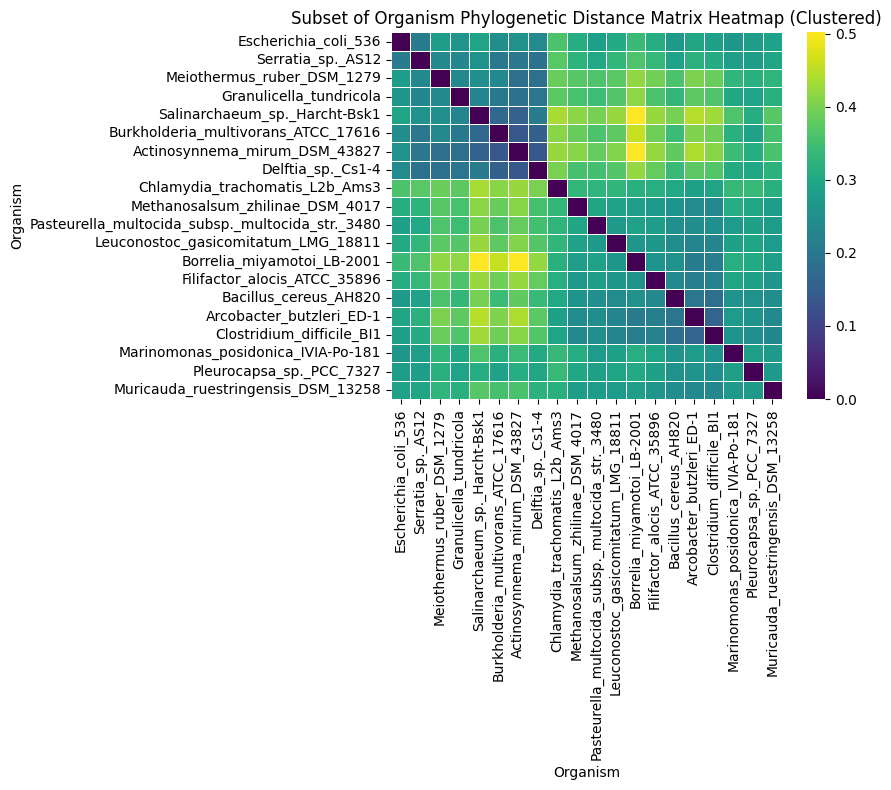

In [18]:
subset_organisms = distance_mat_df.index[:20]
subset_distance_matrix = distance_mat_df.loc[subset_organisms, subset_organisms].copy() # Use .copy() to avoid SettingWithCopyWarning

# Perform hierarchical clustering
condensed_distance = squareform(subset_distance_matrix, checks=False) # checks=False to handle potential NaNs/Infs if not already masked
linked = linkage(condensed_distance, 'weighted') # Use 'weighted' linkage

order = dendrogram(linked, no_plot=True)['leaves']
reordered_distance_matrix = subset_distance_matrix.iloc[order, order]

# Plot the heatmap
plt.figure(figsize=(9, 8))
sns.heatmap(reordered_distance_matrix, cmap="viridis", annot=False, fmt=".2f", linewidths=.5, annot_kws={"size": 8}) # Add mask and adjust annot_kws for readability
plt.title('Subset of Organism Phylogenetic Distance Matrix Heatmap (Clustered)')
plt.xlabel('Organism')
plt.ylabel('Organism')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

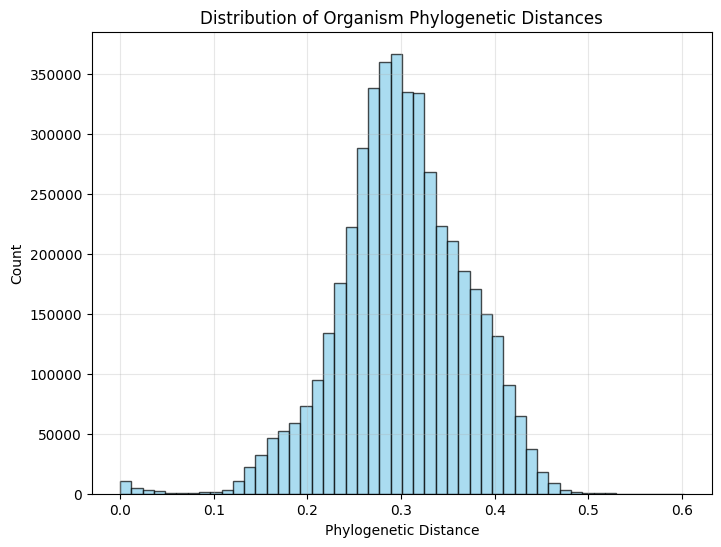

In [19]:
# Plot a histogram of organism distances

# Extract unique distances from the phylogenetic distance matrix (excluding lower triangle)
upper_triangle = distance_mat_df.where(np.triu(np.ones(distance_mat_df.shape), k=0).astype(bool))

# Flatten the upper triangle and drop NaN values (which correspond to the lower triangle and diagonal)
distances = distance_mat_df.stack().values

# Filter out -1 values which indicate missing data or errors
distances = distances[distances != -1]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(distances, bins=50, density=False, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Phylogenetic Distance')
plt.ylabel('Count')
plt.title('Distribution of Organism Phylogenetic Distances')
plt.grid(True, alpha=0.3)
plt.show()

## Load & Create datasets

In [20]:
def prepare_dataset(file_path, hk_mean=None, hk_std=None, scale_input=True):
    """
    Loads a dataframe from a file path, extracts embeddings, organisms,
    indices, hk_genes, and rr_genes, scales the HK embeddings (optionally),
    and creates a CognateDataset.
    Deletes the loaded dataframe to free up memory.

    Args:
        file_path (str): The path to the dataframe file (e.g., pickle).
        hk_mean (np.ndarray, optional): Mean of training HK embeddings for scaling.
                                       If None, calculated from the input df if scaling is enabled.
        hk_std (np.ndarray, optional): Standard deviation of training HK embeddings for scaling.
                                      If None, calculated from the input df if scaling is enabled.
        scale_embeddings (bool): If True, scale the HK embeddings using mean and standard deviation.

    Returns:
        tuple: (dataset, organisms, indices, hk_genes, rr_genes, hk_mean, hk_std)
               where hk_mean and hk_std are returned if calculated from this df.
    """
    df = pd.read_pickle(file_path)

    hk_array = np.array(df['hk_embedding'].tolist())
    rr_array = np.array(df['rr_embedding'].tolist())
    organisms = [org.replace(' ', '_') for org in df['organism'].tolist()]
    # Keep the original index as a list
    indices = df.index.tolist()
    hk_genes = df['hk_gene'].tolist()
    rr_genes = df['rr_gene'].tolist()
    # Scale the embeddings if the flag is True
    if scale_input:
        if hk_mean is None or hk_std is None:
            # Calculate mean and standard deviation from this dataframe (presumably training)
            hk_mean = hk_array.mean(axis=0)
            hk_std = hk_array.std(axis=0)

        # Apply scaling
        # Add epsilon for numerical stability in case of zero std
        hk_scaled = (hk_array - hk_mean) / (hk_std + 1e-8)
    else:
        # If not scaling, use the original embeddings
        hk_scaled = hk_array
        hk_mean = None # Ensure mean and std are None if not scaled
        hk_std = None


    # Create Dataset instance with indices, organisms, hk_genes, and rr_genes
    dataset = CognateDataset(
        hk_embeddings=hk_scaled,
        rr_embeddings=rr_array,
        organisms=organisms,
        indices=indices, # Pass the collected indices
        hk_genes=hk_genes,
        rr_genes=rr_genes
    )

    # Delete the input dataframe to free up memory
    del df
    gc.collect()

    return dataset, organisms, indices, hk_genes, rr_genes, hk_mean, hk_std

In [21]:
%%memit

# train_dataset, organisms_train, indices_train, hk_genes_train, rr_genes_train, hk_train_mean, hk_train_std = prepare_dataset(TRAIN_FILE_PATH, scale_input=SCALE_INPUT)
# save hk_train_mean and hk_train_std to one npy file
# np.save(DATA_PATH / "embeddings" / BASE_MODEL / "train_validation_test_split" / "hk_train_mean_std.npy", (hk_train_mean, hk_train_std))
# load hk_train_mean and hk_train_std from the npy file
hk_train_mean, hk_train_std = np.load(DATA_PATH / "embeddings" / BASE_MODEL / "train_validation_test_split" / "hk_train_mean_std.npy")

# Prepare datasets and get scaling parameters from the training set
all_dataset, organisms_all, indices_all, hk_genes_all, rr_genes_all, _, _ = prepare_dataset(ALL_FILE_PATH, hk_mean=hk_train_mean, hk_std=hk_train_std, scale_input=SCALE_INPUT)

# Use the mean and std from the training set to scale validation and test sets
val_dataset, organisms_val, indices_val, hk_genes_val, rr_genes_val, _, _ = prepare_dataset(VAL_FILE_PATH, hk_mean=hk_train_mean, hk_std=hk_train_std, scale_input=SCALE_INPUT)
test_dataset, organisms_test, indices_test, hk_genes_test, rr_genes_test, _, _ = prepare_dataset(TEST_FILE_PATH, hk_mean=hk_train_mean, hk_std=hk_train_std, scale_input=SCALE_INPUT)

# Create DataLoaders
# Use custom batch sampler for training
all_sampler = OrganismBatchSampler(all_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Passed batchsampler")
all_dataloader = DataLoader(all_dataset, batch_sampler=all_sampler, num_workers=2)
print(f"Passed dataloader")
# train_sampler = OrganismBatchSampler(organisms_train, batch_size=BATCH_SIZE, shuffle=True)
# train_dataloader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=2)

# Use regular DataLoader for validation and test (no need for organism-complete batches for evaluation)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Datasets and DataLoaders created.")

all_df = pd.read_pickle(ALL_FILE_PATH)
test_df = pd.read_pickle(TEST_FILE_PATH)

print("Test Dataframe loaded.")

Passed batchsampler
Passed dataloader
Datasets and DataLoaders created.
Test Dataframe loaded.
peak memory: 11922.84 MiB, increment: 11175.91 MiB


**Load Orphans**

In [22]:
# orphans_df = pd.read_pickle(DATA_PATH / "embeddings" / "esm3-medium" / "all_embeddings" / "p2cs_orphans_data_and_mean_embeddings_esm3-medium-2024-08.pkl")

# orphan_embeddings = np.array(orphans_df['embeddings'].tolist())

# orphan_embeddings = (orphan_embeddings - hk_train_mean) / (hk_train_std + 1e-8)

**Add (train/val/test) set column to all_df**

In [23]:
# all_df['set'] = None
# all_df.loc[all_df['hk_gene'].isin(hk_genes_train), 'set'] = 'train'
# all_df.loc[all_df['hk_gene'].isin(hk_genes_val), 'set'] = 'val'
# all_df.loc[all_df['hk_gene'].isin(hk_genes_test), 'set'] = 'test'

# all_df.to_pickle(ALL_FILE_PATH)

In [24]:
# collect garbage
gc.collect()
%memit

peak memory: 10487.41 MiB, increment: 0.12 MiB


## Instantiate Models

In [25]:
hk_vae = None
# hk_vae = VAE(input_dim=INPUT_DIM, latent_dim=INPUT_DIM).to(DEVICE)
# hk_vae.load_state_dict(torch.load(DATA_PATH / "model weights" / "1536_model_weights_expert-river-36.pth"), map_location=torch.device(DEVICE)))
model = DualHeadAdapter(input_dim=INPUT_DIM, embed_dim=EMBED_DIM,
                        temperature=TEMP, gamma=GAMMA).to(DEVICE)
# adversary = PhylogeneticAdversary(half_input_dim=EMBED_DIM,
#                                   dropout=ADVERSARY_DROPOUT_FRAC, 
#                                   lambda_param=ADVERSARY_LAMBDA,
#                                   reverse_gradient=ENABLE_GRADIENT_REVERSAL)

# print model number of parameters
print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")
# print(f"Adversary has {sum(p.numel() for p in adversary.parameters())} parameters")
# print(f"Adversary lambda: {adversary.lambda_param}")

Model has 3639297 parameters


Evaluating on Test Set: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Test set loss: 7.3654



Generating Embeddings for Evaluation: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


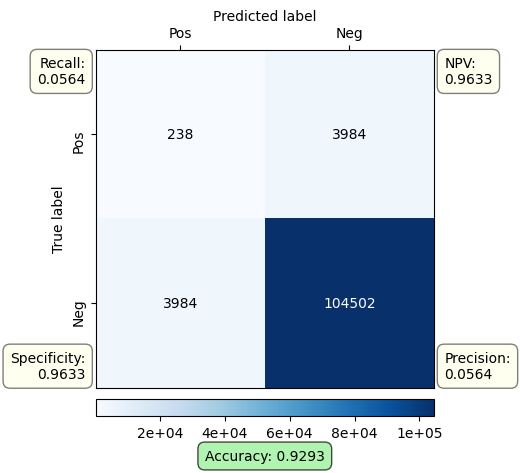


Confusion Matrix and Metrics:
TP: 238, TN: 104502, FP: 3984, FN: 3984
Accuracy: 0.9293
Precision: 0.0564
Recall (Sensitivity): 0.0564
Specificity: 0.9633
NPV: 0.9633


Generating Embeddings for Evaluation: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


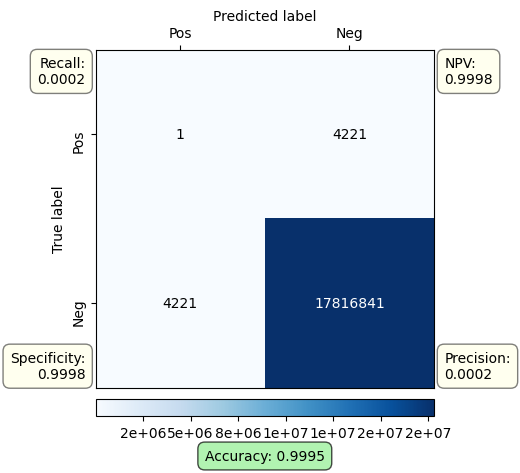


Confusion Matrix and Metrics (Unrestricted):
TP: 1, TN: 17816841, FP: 4221, FN: 4221
Accuracy: 0.9995
Precision: 0.0002
Recall (Sensitivity): 0.0002
Specificity: 0.9998
NPV: 0.9998


In [26]:
# Evaluate the untrained model on the test set
test_loss = evaluate_model(model, test_dataloader, device=DEVICE, gamma=GAMMA, hk_vae=None)
print(f"Test set loss: {test_loss:.4f}\n")

K = 1
T = None

# Evaluate TopK per organism
results_restricted = analyze_cognate_prediction_confusion_matrix(model, test_dataloader, device=DEVICE, k=K, threshold=T, restrict_organism=True, hk_vae=None)
print("\nConfusion Matrix and Metrics:")
print(f"TP: {results_restricted['TP']}, TN: {results_restricted['TN']}, FP: {results_restricted['FP']}, FN: {results_restricted['FN']}")
print(f"Accuracy: {results_restricted['accuracy']:.4f}")
print(f"Precision: {results_restricted['precision']:.4f}")
print(f"Recall (Sensitivity): {results_restricted['recall']:.4f}")
print(f"Specificity: {results_restricted['specificity']:.4f}")
print(f"NPV: {results_restricted['npv']:.4f}")

# Evaluate TopK unrestricted
results_unrestricted = analyze_cognate_prediction_confusion_matrix(model, test_dataloader, device=DEVICE, k=K, threshold=T, restrict_organism=False, hk_vae=None)
print("\nConfusion Matrix and Metrics (Unrestricted):")
print(f"TP: {results_unrestricted['TP']}, TN: {results_unrestricted['TN']}, FP: {results_unrestricted['FP']}, FN: {results_unrestricted['FN']}")
print(f"Accuracy: {results_unrestricted['accuracy']:.4f}")
print(f"Precision: {results_unrestricted['precision']:.4f}")
print(f"Recall (Sensitivity): {results_unrestricted['recall']:.4f}")
print(f"Specificity: {results_unrestricted['specificity']:.4f}")
print(f"NPV: {results_unrestricted['npv']:.4f}")

## Load Model Weights

In [27]:
model_params = PARAMS_DICT[BASE_MODEL]

# Check if 'trained_weights_filename' exists for the chosen BASE_MODEL
if 'trained_weights_filename' not in model_params:
    print(f"Error: 'trained_weights_filename' not found for BASE_MODEL '{BASE_MODEL}' in PARAMS_DICT.")
else:
    model_filename = model_params['trained_weights_filename']
    model_path = DATA_PATH / 'model_weights' / model_filename

    state_dict = torch.load(model_path, map_location=torch.device(DEVICE))
    model.load_state_dict(state_dict)
    print(f"Model weights loaded successfully from {model_path}")

Model weights loaded successfully from /zdata/user-data/noam/data/p2cs/model_weights/best_accuracy_woven-dew-92.pth


## Evaluate

### Plot confusion matrices

Evaluating on Test Set: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Test set loss: 1.7066



Generating Embeddings for Evaluation: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


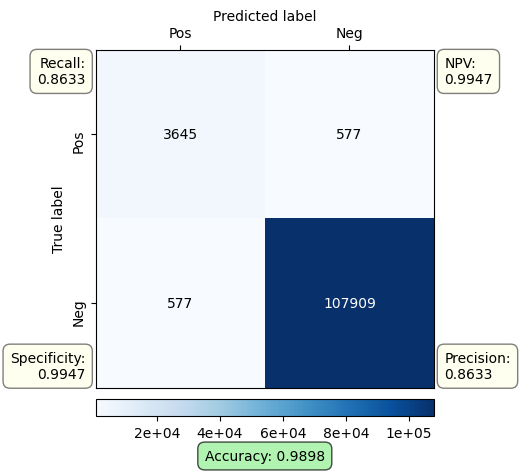


Confusion Matrix and Metrics:
TP: 3645, TN: 107909, FP: 577, FN: 577
Accuracy: 0.9898
Precision: 0.8633
Recall (Sensitivity): 0.8633
Specificity: 0.9947
NPV: 0.9947


Generating Embeddings for Evaluation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


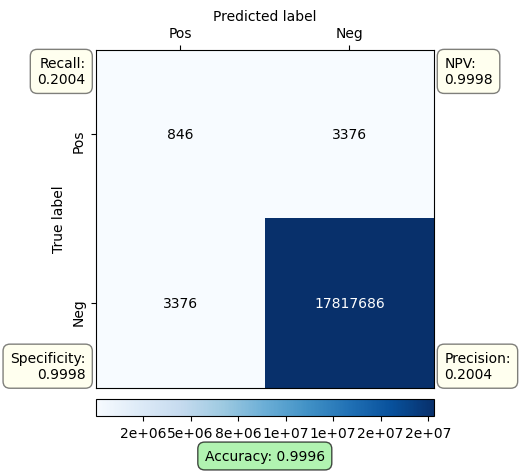


Confusion Matrix and Metrics (Unrestricted):
TP: 846, TN: 17817686, FP: 3376, FN: 3376
Accuracy: 0.9996
Precision: 0.2004
Recall (Sensitivity): 0.2004
Specificity: 0.9998
NPV: 0.9998


In [28]:
# Evaluate the best model on the test set
test_loss = evaluate_model(model, test_dataloader, device=DEVICE, gamma=GAMMA, hk_vae=None)
print(f"Test set loss: {test_loss:.4f}\n")

K = 1
T = None # 0.55

# Evaluate TopK per organism
results_restricted = analyze_cognate_prediction_confusion_matrix(model, test_dataloader, device=DEVICE, k=K, threshold=T, restrict_organism=True, hk_vae=None)
print("\nConfusion Matrix and Metrics:")
print(f"TP: {results_restricted['TP']}, TN: {results_restricted['TN']}, FP: {results_restricted['FP']}, FN: {results_restricted['FN']}")
print(f"Accuracy: {results_restricted['accuracy']:.4f}")
print(f"Precision: {results_restricted['precision']:.4f}")
print(f"Recall (Sensitivity): {results_restricted['recall']:.4f}")
print(f"Specificity: {results_restricted['specificity']:.4f}")
print(f"NPV: {results_restricted['npv']:.4f}")

# Evaluate TopK unrestricted
results_unrestricted = analyze_cognate_prediction_confusion_matrix(model, test_dataloader, device=DEVICE, k=K, threshold=T, restrict_organism=False, hk_vae=None)
print("\nConfusion Matrix and Metrics (Unrestricted):")
print(f"TP: {results_unrestricted['TP']}, TN: {results_unrestricted['TN']}, FP: {results_unrestricted['FP']}, FN: {results_unrestricted['FN']}")
print(f"Accuracy: {results_unrestricted['accuracy']:.4f}")
print(f"Precision: {results_unrestricted['precision']:.4f}")
print(f"Recall (Sensitivity): {results_unrestricted['recall']:.4f}")
print(f"Specificity: {results_unrestricted['specificity']:.4f}")
print(f"NPV: {results_unrestricted['npv']:.4f}")

### Plot by number of cognates

In [30]:
# add num_rr_cognates to test_df

groups_df = pd.read_pickle("/zdata/user-data/noam/data/p2cs/p2cs_filtered_groups.pkl")

hk_subset = groups_df[groups_df['class'] == 'HK']

# for all hk's in a proximity group, the number of rr cognates is the same
proximity_group_to_num_rr_cognates = hk_subset.set_index('proximity_group')['num_cognates'].groupby('proximity_group').first()

# in test_df, for each row, which has a pair of hk and rr, take the first 'num_cognates' value of the hk_subset for that proximity_group
test_df['num_rr_cognates'] = test_df['proximity_group'].map(proximity_group_to_num_rr_cognates)

In [31]:
# Evaluate accuracy per proximity group size

# Use the test_dataloader directly to get embeddings and other information
hk_emb_test_all, rr_emb_test_all, organisms_test_all, indices_test_all, hk_genes_test_all, rr_genes_test_all = [], [], [], [], [], []

model.eval()
if hk_vae is not None:
    hk_vae.eval()

with torch.no_grad():
    for (hk_batch_data, rr_batch_data, organism, hk_gene, rr_gene), indices in tqdm(test_dataloader, desc="Collecting Embeddings for Proximity Group Evaluation"):
        hk_batch_data, rr_batch_data = hk_batch_data.to(DEVICE), rr_batch_data.to(DEVICE)

        # Pass HK data through VAE encoder if VAE is provided
        if hk_vae is not None:
            mu, logvar = hk_vae.encode(hk_batch_data)
            hk_input_for_adapter = mu
        else:
            hk_input_for_adapter = hk_batch_data

        hk_emb, rr_emb, temp, gamma = model(hk_input_for_adapter, rr_batch_data)
        hk_emb_test_all.append(hk_emb) # Keep as tensors for now
        rr_emb_test_all.append(rr_emb) # Keep as tensors for now
        organisms_test_all.extend(organism)
        indices_test_all.extend(indices.tolist()) # Collect indices
        hk_genes_test_all.extend(hk_gene) # Collect hk_genes
        rr_genes_test_all.extend(rr_gene) # Collect rr_genes
# Concatenate embeddings into single tensors
hk_emb_test_all = torch.cat(hk_emb_test_all, dim=0)
rr_emb_test_all = torch.cat(rr_emb_test_all, dim=0)

Calculating proximity group size accuracy (GPU-optimized)...
Calculation completed in 0.05 seconds

Accuracy by Proximity Group Size:
Proximity Group Size 1: 0.9138
Proximity Group Size 2: 0.4518
Proximity Group Size 3: 0.2778
Proximity Group Size 4: 0.2500
Proximity Group Size 6: 0.1111


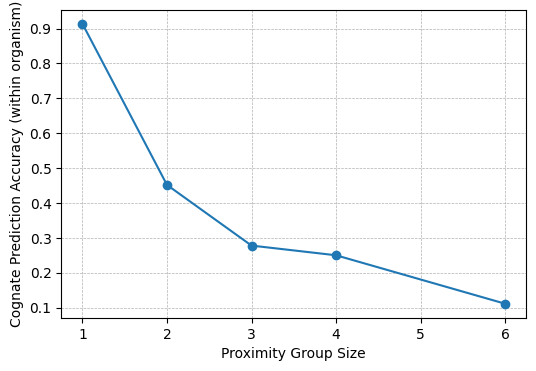

In [32]:
# Calculate proximity group size accuracy with timing
print("Calculating proximity group size accuracy (GPU-optimized)...")
start_time = time.time()

# Pass the collected embeddings, organisms, indices, hk_genes, rr_genes, and the original test_df
proximity_group_accuracy = calculate_cognate_accuracy_per_group(
    hk_emb_test_all, rr_emb_test_all, organisms_test_all, indices_test_all, hk_genes_test_all, rr_genes_test_all, test_df, group_by='proximity_group_size', device=DEVICE
)

end_time = time.time()
print(f"Calculation completed in {end_time - start_time:.2f} seconds")

print("\nAccuracy by Proximity Group Size:")
for size, accuracy in sorted(proximity_group_accuracy.items()):
    print(f"Proximity Group Size {size}: {accuracy:.4f}")

# Convert dictionary to sorted lists for plotting
group_sizes = sorted(proximity_group_accuracy.keys())
accuracies = [proximity_group_accuracy[size] for size in group_sizes]

plt.figure(figsize=(6, 4))
plt.plot(group_sizes, accuracies, marker='o', linestyle='-')
# plt.xscale('log')
plt.xlabel('Proximity Group Size')
plt.ylabel('Cognate Prediction Accuracy (within organism)')
# plt.title('Cognate Prediction Accuracy vs. Proximity Group Size')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

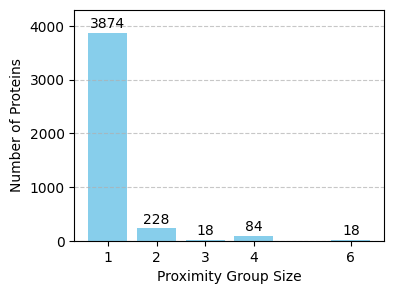

In [33]:
# Count the occurrences of each proximity group size
proximity_group_size_counts = test_df['proximity_group_size'].value_counts().sort_index()

# Extract data for plotting
sizes = proximity_group_size_counts.index
counts = proximity_group_size_counts.values

# Create the histogram
plt.figure(figsize=(4, 3))
plt.bar(sizes, counts, width=0.8, color='skyblue')
plt.xlabel('Proximity Group Size')
plt.ylabel('Number of Proteins')
# plt.title('Distribution of Proteins by Proximity Group Size in Test Set')
plt.xticks(sizes) # Ensure all group sizes are shown as ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 4300)
# Add a label above each bar for clarity
for i, count in enumerate(counts):
    plt.text(sizes[i], count + max(counts) * 0.01, str(count), ha='center', va='bottom')

plt.show()

Calculating number of RR cognates accuracy (GPU-optimized)...
Calculation completed in 0.05 seconds

Accuracy by Number of RR cognates:
Number of RR cognates 1.0: 0.8986
Number of RR cognates 2.0: 0.3889
Number of RR cognates 3.0: 0.2000


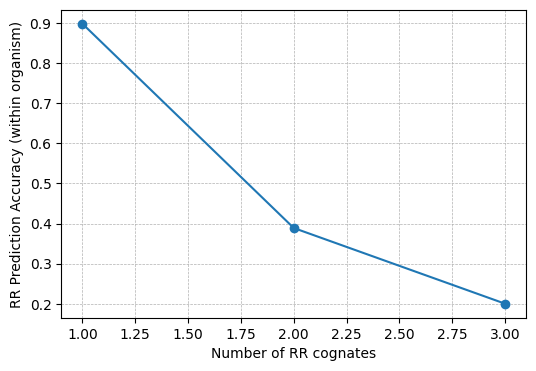

In [34]:
# Calculate number of RR cognates accuracy with timing
print("Calculating number of RR cognates accuracy (GPU-optimized)...")
start_time = time.time()

# Pass the collected embeddings, organisms, indices, hk_genes, rr_genes, and the original test_df
proximity_group_accuracy = calculate_cognate_accuracy_per_group(
    hk_emb_test_all, rr_emb_test_all, organisms_test_all, indices_test_all, hk_genes_test_all, rr_genes_test_all, test_df, group_by='num_rr_cognates', device=DEVICE
)

end_time = time.time()
print(f"Calculation completed in {end_time - start_time:.2f} seconds")

print("\nAccuracy by Number of RR cognates:")
for size, accuracy in sorted(proximity_group_accuracy.items()):
    print(f"Number of RR cognates {size}: {accuracy:.4f}")

# Convert dictionary to sorted lists for plotting
group_sizes = sorted(proximity_group_accuracy.keys())
accuracies = [proximity_group_accuracy[size] for size in group_sizes]

plt.figure(figsize=(6, 4))
plt.plot(group_sizes, accuracies, marker='o', linestyle='-')
# plt.xscale('log')
plt.xlabel('Number of RR cognates')
plt.ylabel('RR Prediction Accuracy (within organism)')
# plt.title('Cognate Prediction Accuracy vs. Cognate Count')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

In [35]:
# Calculate number of RR cognates accuracy with timing
print("Calculating number of RR cognates accuracy (GPU-optimized)...")
start_time = time.time()

# Pass the collected embeddings, organisms, indices, hk_genes, rr_genes, and the original test_df
number_rr_cognates_accuracy = calculate_cognate_topk_accuracy_per_proximity_group_k(
    hk_emb_test_all, rr_emb_test_all, organisms_test_all, indices_test_all, hk_genes_test_all, test_df, device=DEVICE
)

end_time = time.time()
print(f"Calculation completed in {end_time - start_time:.2f} seconds")

print("\nAccuracy by Number of RR cognates:")
for size, accuracy in sorted(number_rr_cognates_accuracy.items()):
    print(f"Number of RR cognates {size}: {accuracy:.4f}")

# Convert dictionary to sorted lists for plotting
number_rr_cognates_sizes = sorted(number_rr_cognates_accuracy.keys())
accuracies = [number_rr_cognates_accuracy[size] for size in number_rr_cognates_sizes]

plt.figure(figsize=(6, 4))
plt.plot(number_rr_cognates_sizes, accuracies, marker='o', linestyle='-')
# plt.xscale('log')
plt.xlabel('K (number of RR cognates)')
plt.ylabel('% Cognates in the top K predictions\n(within organism)')
# plt.title('Cognate Prediction Accuracy vs. Proximity Group Size')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

Calculating number of RR cognates accuracy (GPU-optimized)...


TypeError: calculate_cognate_topk_accuracy_per_proximity_group_k() missing 1 required positional argument: 'df_original'

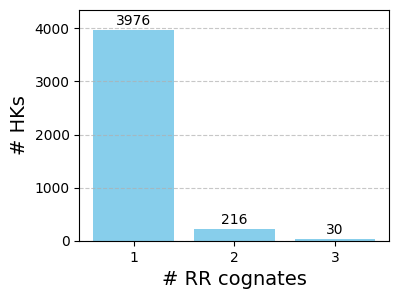

In [ ]:
# Count the occurrences of each number of RR cognates
number_rr_cognates_counts = test_df['num_rr_cognates'].value_counts().sort_index()

# Extract data for plotting
sizes = number_rr_cognates_counts.index
counts = number_rr_cognates_counts.values

# Create the histogram
plt.figure(figsize=(4, 3))
plt.bar(sizes, counts, width=0.8, color='skyblue')
plt.xlabel('# RR cognates', fontsize=14)
plt.ylabel('# HKs', fontsize=14)
# plt.title('Distribution of Proteins by Number of RR cognates in Test Set')
plt.xticks(sizes) # Ensure all group sizes are shown as ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 4350)
# Add a label above each bar for clarity
for i, count in enumerate(counts):
    plt.text(sizes[i], count + max(counts) * 0.01, str(count), ha='center', va='bottom')

plt.show()

### By organism

#### Calculate

In [ ]:
# Evaluate accuracy per organism

# Generate embeddings for the entire test set by iterating through the dataloader
hk_emb_test_list, rr_emb_test_list = [], []
organisms_test_list = []
hk_genes_test_list = []
rr_genes_test_list = []
indices_test_list = [] # Collect indices to reconstruct dataframe if needed

model.eval()
if hk_vae is not None:
    hk_vae.eval()

with torch.no_grad():
    for (hk_batch_data, rr_batch_data, organism, hk_gene, rr_gene), indices in tqdm(test_dataloader, desc="Generating Embeddings for Per-Organism Evaluation"):
        hk_batch_data, rr_batch_data = hk_batch_data.to(DEVICE), rr_batch_data.to(DEVICE)

        # Pass HK data through VAE encoder if VAE is provided
        if hk_vae is not None:
            mu, logvar = hk_vae.encode(hk_batch_data)
            hk_input_for_adapter = mu
        else:
            hk_input_for_adapter = hk_batch_data

        hk_emb, rr_emb, temp, gamma = model(hk_input_for_adapter, rr_batch_data)

        hk_emb_test_list.append(hk_emb.cpu())
        rr_emb_test_list.append(rr_emb.cpu())
        organisms_test_list.extend(organism)
        hk_genes_test_list.extend(hk_gene)
        rr_genes_test_list.extend(rr_gene)
        indices_test_list.extend(indices.tolist())

# Concatenate embeddings into single tensors on CPU
hk_emb_test_all = torch.cat(hk_emb_test_list, dim=0)
rr_emb_test_all = torch.cat(rr_emb_test_list, dim=0)

# Create a new dataframe for evaluation results, including embeddings
# Use the collected indices to ensure alignment with original test_df if needed later
eval_df = pd.DataFrame({
    'organism': organisms_test_list,
    'hk_gene': hk_genes_test_list,
    'rr_gene': rr_genes_test_list,
    'hk_predicted_embedding': hk_emb_test_all.tolist(), # Convert tensor to list of lists
    'rr_predicted_embedding': rr_emb_test_all.tolist(), # Convert tensor to list of lists
}, index=indices_test_list) # Use collected indices
# Add proximity group size and number of RR cognates to eval_df
eval_df['proximity_group_size'] = test_df.loc[eval_df.index, 'proximity_group_size']
eval_df['num_rr_cognates'] = test_df.loc[eval_df.index, 'num_rr_cognates']

# Calculate per-organism accuracy
print("Calculating per-organism accuracy...")
start_time = time.time()

# Use the new eval_df which contains the generated embeddings
organism_accuracy = calculate_cognate_accuracy_per_organism(eval_df, device=DEVICE)

end_time = time.time()
print(f"Calculation completed in {end_time - start_time:.2f} seconds")

# Add original proximity group size from the test_df to eval_df for plotting later
# We need to load the original test_df for this
original_test_df = pd.read_pickle(TEST_FILE_PATH)
eval_df['proximity_group_size'] = original_test_df.loc[eval_df.index, 'proximity_group_size']
del original_test_df
gc.collect()


print(f"\nTotal organisms evaluated: {len(organism_accuracy)}")
print(f"Mean accuracy across organisms: {np.mean(list(organism_accuracy.values())):.4f}")
print(f"Median accuracy across organisms: {np.median(list(organism_accuracy.values())):.4f}")


# Sort organisms by accuracy
sorted_organisms = sorted(organism_accuracy.items(), key=lambda x: x[1], reverse=True)

# Show best and worst performing organisms
print("\nTop 10 Best Performing Organisms:")
for i, (organism, accuracy) in enumerate(sorted_organisms[:10]):
    organism_size = len(eval_df[eval_df['organism'] == organism])
    print(f"{i+1:2d}. {organism}: {accuracy:.4f} (n={organism_size})")

print("\nTop 10 Worst Performing Organisms:")
for i, (organism, accuracy) in enumerate(sorted_organisms[-10:]):
    organism_size = len(eval_df[eval_df['organism'] == organism])
    print(f"{i+1:2d}. {organism}: {accuracy:.4f} (n={organism_size})")


Generating Embeddings for Per-Organism Evaluation: 100%|██████████| 5/5 [00:00<00:00,  9.99it/s]


KeyError: 'num_rr_cognates'

#### Plot

/zdata/user-data/noam/.conda/envs/python310/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:84: UserWarning: Blended transforms not yet supported. Zoom behavior may not work as expected.
  warnings.warn("Blended transforms not yet supported. "


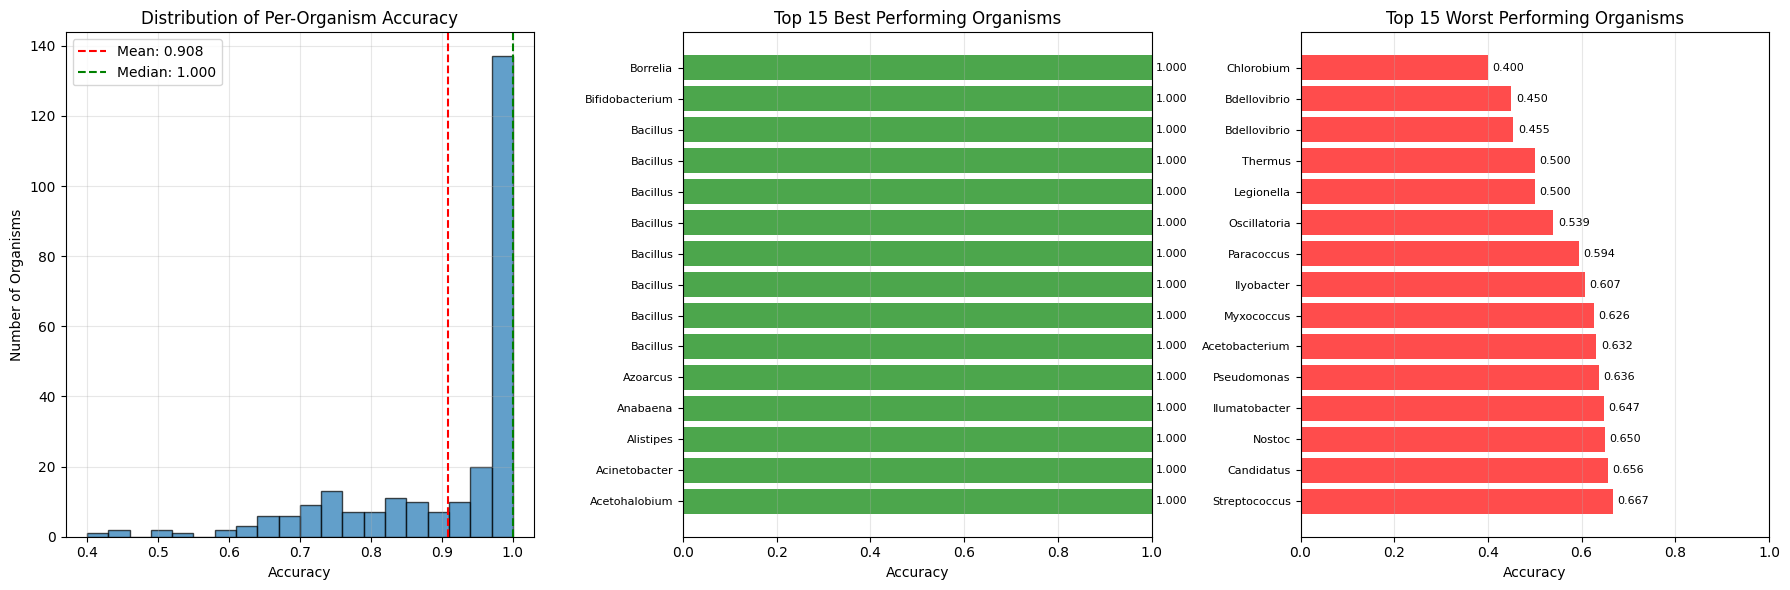

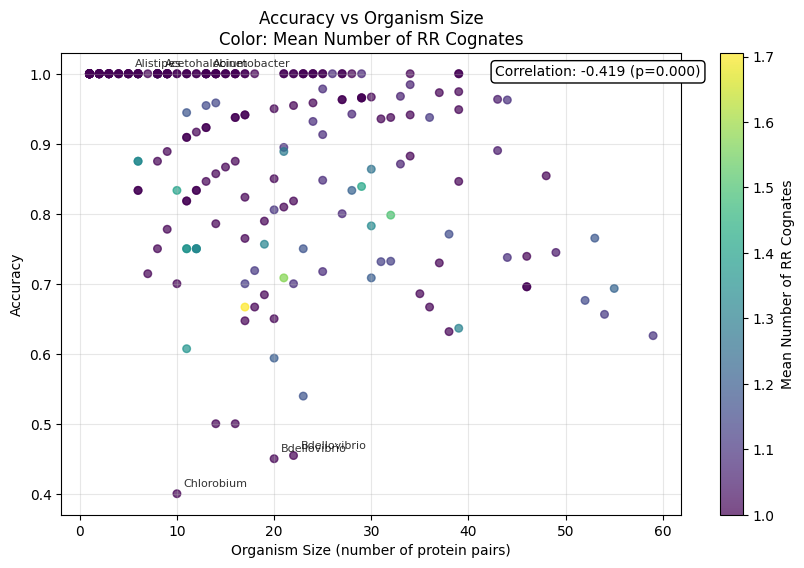


Correlation between organism size and accuracy: -0.419 (p-value: 0.000)


In [ ]:
# Create visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# 1. Histogram of accuracies
accuracies = list(organism_accuracy.values())
ax1.hist(accuracies, bins=20, alpha=0.7, edgecolor='black')
ax1.axvline(np.mean(accuracies), color='red', linestyle='--', label=f'Mean: {np.mean(accuracies):.3f}')
ax1.axvline(np.median(accuracies), color='green', linestyle='--', label=f'Median: {np.median(accuracies):.3f}')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('Number of Organisms')
ax1.set_title('Distribution of Per-Organism Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Best performing organisms
best_organisms = sorted_organisms[:15]  # Top 15
best_names = [org.split('_')[0] if '_' in org else org[:10] for org, _ in best_organisms]  # Shortened names
best_accuracies = [acc for _, acc in best_organisms]

ax2.barh(range(len(best_names)), best_accuracies, color='green', alpha=0.7)
ax2.set_yticks(range(len(best_names)))
ax2.set_yticklabels(best_names, fontsize=8)
ax2.set_xlabel('Accuracy')
ax2.set_title('Top 15 Best Performing Organisms')
ax2.set_xlim(0, 1)
ax2.grid(True, alpha=0.3, axis='x')

# Add accuracy values on bars
for i, acc in enumerate(best_accuracies):
    ax2.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=8)

# 3. Worst performing organisms
worst_organisms = sorted_organisms[-15:]  # Bottom 15
worst_names = [org.split('_')[0] if '_' in org else org[:10] for org, _ in worst_organisms]  # Shortened names
worst_accuracies = [acc for _, acc in worst_organisms]

ax3.barh(range(len(worst_names)), worst_accuracies, color='red', alpha=0.7)
ax3.set_yticks(range(len(worst_names)))
ax3.set_yticklabels(worst_names, fontsize=8)
ax3.set_xlabel('Accuracy')
ax3.set_title('Top 15 Worst Performing Organisms')
ax3.set_xlim(0, 1)
ax3.grid(True, alpha=0.3, axis='x')

# Add accuracy values on bars
for i, acc in enumerate(worst_accuracies):
    ax3.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# ----- Begin modified scatter plot coloring section -----

# Compute mean number of RR cognates for each organism - FIXED LOGIC
mean_num_rr_cognates = {}
for organism in organism_accuracy:
    org_df = eval_df[eval_df['organism'] == organism]
    num_rr_cognates = org_df['num_rr_cognates']
    # The mean number of RR cognates for this organism
    if len(num_rr_cognates) > 0:
        mean_rr = num_rr_cognates.mean()
    else:
        mean_rr = np.nan
    mean_num_rr_cognates[organism] = mean_rr

organism_sizes = []
organism_accs = []
organism_num_rr_cognates = []
for organism, accuracy in organism_accuracy.items():
    size = len(eval_df[eval_df['organism'] == organism])
    organism_sizes.append(size)
    organism_accs.append(accuracy)
    organism_num_rr_cognates.append(mean_num_rr_cognates[organism])

# Plot accuracy vs organism size, colored by mean number of RR cognates
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    organism_sizes, organism_accs,
    c=organism_num_rr_cognates,
    cmap='viridis', alpha=0.7, s=30
)
plt.xlabel('Organism Size (number of protein pairs)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Organism Size\nColor: Mean Number of RR Cognates')
plt.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, label='Mean Number of RR Cognates')

# Add trend line
correlation, p_value = pearsonr(organism_sizes, organism_accs)
plt.text(0.7, 0.95, f'Correlation: {correlation:.3f} (p={p_value:.3f})',
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

# Add some organism labels for extreme cases
for i, (organism, accuracy) in enumerate(sorted_organisms[:3] + sorted_organisms[-3:]):
    size = len(eval_df[eval_df['organism'] == organism])
    plt.annotate(organism.split('_')[0] if '_' in organism else organism[:10],
                xy=(size, accuracy), xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

plt.show()

print(f"\nCorrelation between organism size and accuracy: {correlation:.3f} (p-value: {p_value:.3f})")

# # Clean up the evaluation dataframe
# del eval_df
# gc.collect()

#### Specific organisms

In [ ]:
def evaluate_organisms_by_prefix(eval_df, prefix, device='cuda', k=1, threshold=None):
    """
    Filters organisms in eval_df by a prefix and calculates accuracy and
    confusion matrix components for the filtered subset.

    Args:
        eval_df (DataFrame): DataFrame containing organism, hk_predicted_embedding,
                             and rr_predicted_embedding columns.
        prefix (str): The prefix to filter organism names by.
        device (str): Device to use for computation ('cuda' or 'cpu').
        k: The number of nearest neighbors to consider as cognates.
        threshold: The similarity threshold.

    Returns:
        dict: A dictionary where keys are organism names (filtered by prefix)
              and values are dictionaries containing 'accuracy' and
              confusion matrix components ('TP', 'TN', 'FP', 'FN').
    """
    results = {}

    # Filter the dataframe by organism prefix
    filtered_df = eval_df[eval_df['organism'].str.startswith(prefix)].copy()

    if filtered_df.empty:
        print(f"No organisms found with prefix '{prefix}'")
        return results

    # Get unique organisms in the filtered subset
    unique_organisms_filtered = filtered_df['organism'].unique().tolist()

    print(f"Evaluating {len(unique_organisms_filtered)} organisms starting with '{prefix}'...")

    for organism in tqdm(unique_organisms_filtered, desc=f"Evaluating organisms with prefix '{prefix}'"):
        organism_df = filtered_df[filtered_df['organism'] == organism].copy()

        total_pairs = len(organism_df)
        if total_pairs == 0:
            results[organism] = {'accuracy': 0, 'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
            continue

        # Extract embeddings and convert to GPU tensors
        hk_embeddings = torch.tensor(
            np.array(organism_df['hk_predicted_embedding'].tolist()),
            dtype=torch.float32,
            device=device
        )  # Shape: [N, embedding_dim]

        rr_embeddings = torch.tensor(
            np.array(organism_df['rr_predicted_embedding'].tolist()),
            dtype=torch.float32,
            device=device
        )  # Shape: [N, embedding_dim]

        # Normalize for cosine similarity
        hk_norm = F.normalize(hk_embeddings, p=2, dim=1)
        rr_norm = F.normalize(rr_embeddings, p=2, dim=1)

        # Calculate similarity matrix within this organism: [N, N]
        similarity_matrix = torch.matmul(hk_norm, rr_norm.T)

        # Determine predictions based on k and/or threshold
        prediction_matrix = torch.zeros(total_pairs, total_pairs, dtype=torch.bool, device=device)

        if threshold is not None:
            threshold_mask = (similarity_matrix >= threshold)
            if k is not None:
                _, top_k_indices = torch.topk(similarity_matrix, k=min(k, total_pairs), dim=1)
                top_k_mask = torch.zeros(total_pairs, total_pairs, dtype=torch.bool, device=device)
                hk_indices_expand = torch.arange(total_pairs, device=device)[:, None].expand(-1, min(k, total_pairs))
                top_k_mask[hk_indices_expand.flatten(), top_k_indices.flatten()] = True
                prediction_matrix = threshold_mask | top_k_mask
            else:
                prediction_matrix = threshold_mask
        elif k is not None:
            _, top_k_indices = torch.topk(similarity_matrix, k=min(k, total_pairs), dim=1)
            top_k_mask = torch.zeros(total_pairs, total_pairs, dtype=torch.bool, device=device)
            hk_indices_expand = torch.arange(total_pairs, device=device)[:, None].expand(-1, min(k, total_pairs))
            top_k_mask[hk_indices_expand.flatten(), top_k_indices.flatten()] = True
            prediction_matrix = top_k_mask
        else:
             # Default to k=1 if neither is specified
             _, top_k_indices = torch.topk(similarity_matrix, k=1, dim=1)
             top_k_mask = torch.zeros(total_pairs, total_pairs, dtype=torch.bool, device=device)
             hk_indices_expand = torch.arange(total_pairs, device=device)[:, None].expand(-1, 1)
             top_k_mask[hk_indices_expand.flatten(), top_k_indices.flatten()] = True
             prediction_matrix = top_k_mask


        # Ground truth matrix (diagonal for cognate pairs within the organism)
        ground_truth_matrix = torch.eye(total_pairs, dtype=torch.bool, device=device)

        # Calculate confusion matrix components
        TP = torch.sum(ground_truth_matrix & prediction_matrix).item()
        FN = torch.sum(ground_truth_matrix & ~prediction_matrix).item()
        FP = torch.sum(~ground_truth_matrix & prediction_matrix).item()
        TN = torch.sum(~ground_truth_matrix & ~prediction_matrix).item()

        # Calculate accuracy
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

        results[organism] = {
            'accuracy': accuracy,
            'TP': TP,
            'TN': TN,
            'FP': FP,
            'FN': FN
        }

    return results

# Example usage:
# Replace 'Escherichia' with the desired prefix
prefix_to_evaluate = 'Escherichia'
# Set k and/or threshold as needed
k_eval = 1
threshold_eval = None # Or a specific threshold like 0.5

evaluation_results = evaluate_organisms_by_prefix(
    eval_df,
    prefix_to_evaluate,
    device=DEVICE,
    k=k_eval,
    threshold=threshold_eval
)

# Print the results
print("\nEvaluation Results:")
for organism, metrics in evaluation_results.items():
    print(f"\nOrganism: {organism}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  TP: {metrics['TP']}, TN: {metrics['TN']}, FP: {metrics['FP']}, FN: {metrics['FN']}")

Evaluating 4 organisms starting with 'Escherichia'...


Evaluating organisms with prefix 'Escherichia': 100%|██████████| 4/4 [00:00<00:00, 622.55it/s]


Evaluation Results:

Organism: Escherichia_coli_Xuzhou21
  Accuracy: 1.0000
  TP: 23, TN: 506, FP: 0, FN: 0

Organism: Escherichia_coli_B_str._REL606
  Accuracy: 1.0000
  TP: 21, TN: 420, FP: 0, FN: 0

Organism: Escherichia_coli_ABU_83972
  Accuracy: 1.0000
  TP: 24, TN: 552, FP: 0, FN: 0

Organism: Escherichia_coli_O104:H4_str._2011C-3493
  Accuracy: 0.9965
  TP: 23, TN: 551, FP: 1, FN: 1


### Precision-Recall Curve

In [36]:
k_values = np.arange(1, 10, 1)  # k from 1 to 50
t_values = np.linspace(0, 1, 20) # 101 thresholds from 0.0 to 1.0
lst_restric_organism = [True]

In [37]:
# Generate ROC data with TP, FP, FN
pr_data_dict = generate_pr_data(model, test_dataloader, DEVICE, k_values, t_values, list_restrict_organism=lst_restric_organism, hk_vae=None)

# Unpack the data for plotting - now from the dictionary
# Assuming lst_restrict_organism has two values: True and False
if True in pr_data_dict:
    tp_topk_restricted, fp_topk_restricted, fn_topk_restricted, tp_threshold_restricted, fp_threshold_restricted, fn_threshold_restricted = pr_data_dict[True]
else:
    # Handle case where restricted data is not generated
    tp_topk_restricted, fp_topk_restricted, fn_topk_restricted = [], [], []
    tp_threshold_restricted, fp_threshold_restricted, fn_threshold_restricted = [], [], []


if False in pr_data_dict:
     tp_topk_unrestricted, fp_topk_unrestricted, fn_topk_unrestricted, tp_threshold_unrestricted, fp_threshold_unrestricted, fn_threshold_unrestricted = pr_data_dict[False]
else:
    # Handle case where unrestricted data is not generated
    tp_topk_unrestricted, fp_topk_unrestricted, fn_topk_unrestricted = [], [], []
    tp_threshold_unrestricted, fp_threshold_unrestricted, fn_threshold_unrestricted = [], [], []


print("PR data generated and unpacked successfully.")

Generating Threshold PR data (Restricted: True): 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]

PR data generated and unpacked successfully.


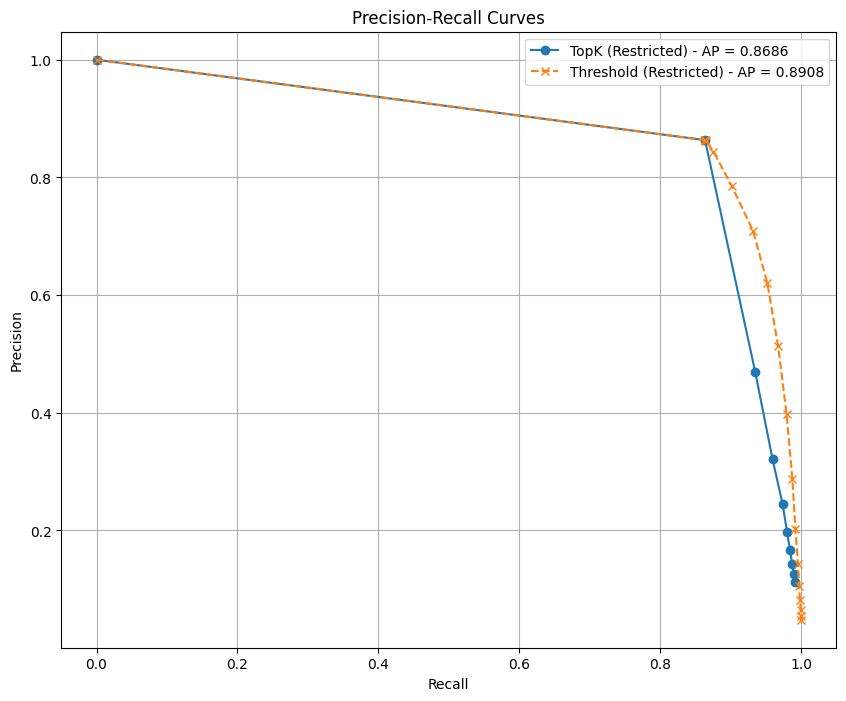

In [38]:
plot_pr_curves(pr_data_dict)

### Compare similarities

#### Project Protein Embeddings

In [29]:
# embed all test set
hk_all_embeddings, rr_all_embeddings, cognate_mask_all, promiscuous_mask_all, org_equal_mask_all, tcs_organism_names_all = coembed(model, all_dataloader, DEVICE)

hk_test_embeddings, rr_test_embeddings, cognate_mask_test, promiscuous_mask_test, org_equal_mask_test, tcs_organism_names_test = coembed(model, test_dataloader, DEVICE)

# calculate similarity matrix
similarity_matrix_all = torch.matmul(hk_all_embeddings, rr_all_embeddings.T).cpu().numpy()
similarity_matrix_test = torch.matmul(hk_test_embeddings, rr_test_embeddings.T).cpu().numpy()

#### Cluster Homologous TCS

In [30]:
p2cs_filtered_groups = pd.read_pickle(base_dir / "merged_p2cs_data" / "p2cs_filtered_groups.pkl")

# Create mapping from Gene to global_cluster
gene_to_cluster = dict(zip(p2cs_filtered_groups['Gene'], p2cs_filtered_groups['global_cluster']))

# Add cluster IDs to p2cs_pairs
all_df['hk_cluster'] = all_df['hk_gene'].map(gene_to_cluster)
all_df['rr_cluster'] = all_df['rr_gene'].map(gene_to_cluster)



In [31]:
# Find pairs of rows where both hk_cluster and rr_cluster match
# We'll use a self-join approach
p2cs_pairs_with_clusters = all_df[['hk_gene', 'rr_gene', 'hk_cluster', 'rr_cluster']].copy()

# Merge with itself to find pairs
pairs_merged = p2cs_pairs_with_clusters.merge(
    p2cs_pairs_with_clusters,
    left_on=['hk_cluster', 'rr_cluster'],
    right_on=['hk_cluster', 'rr_cluster'],
    suffixes=('_1', '_2')
)

# Filter out self-pairs (where hk_gene_1 == hk_gene_2 and rr_gene_1 == rr_gene_2)
# and remove duplicate pairs (where (gene1, gene2) appears as (gene2, gene1))
pairs_merged = pairs_merged[
    ~((pairs_merged['hk_gene_1'] == pairs_merged['hk_gene_2']) & 
      (pairs_merged['rr_gene_1'] == pairs_merged['rr_gene_2']))
]

# Remove duplicate pairs by keeping only pairs where hk_gene_1 < hk_gene_2 or 
# (hk_gene_1 == hk_gene_2 and rr_gene_1 < rr_gene_2)
pairs_merged = pairs_merged[
    (pairs_merged['hk_gene_1'] < pairs_merged['hk_gene_2']) |
    ((pairs_merged['hk_gene_1'] == pairs_merged['hk_gene_2']) & 
     (pairs_merged['rr_gene_1'] < pairs_merged['rr_gene_2']))
]

# Build explicit lookup tables that keep every occurrence's row index
hk_lookup = (
    all_df.reset_index()
    .rename(columns={'index': 'hk_idx'})
    [['hk_gene', 'hk_idx']]
)
rr_lookup = (
    all_df.reset_index()
    .rename(columns={'index': 'rr_idx'})
    [['rr_gene', 'rr_idx']]
)

pairs_with_idx = (
    pairs_merged
    .merge(hk_lookup, left_on='hk_gene_1', right_on='hk_gene', how='left')
    .rename(columns={'hk_idx': 'hk_idx_1'})
    .merge(hk_lookup, left_on='hk_gene_2', right_on='hk_gene', how='left')
    .rename(columns={'hk_idx': 'hk_idx_2'})
    .merge(rr_lookup, left_on='rr_gene_1', right_on='rr_gene', how='left')
    .rename(columns={'rr_idx': 'rr_idx_1'})
    .merge(rr_lookup, left_on='rr_gene_2', right_on='rr_gene', how='left')
    .rename(columns={'rr_idx': 'rr_idx_2'})
    [['hk_idx_1', 'hk_idx_2', 'rr_idx_1', 'rr_idx_2']]
    .dropna()
)

hk_idx_1 = torch.as_tensor(pairs_with_idx['hk_idx_1'].to_numpy(), dtype=torch.long, device=hk_all_embeddings.device)
hk_idx_2 = torch.as_tensor(pairs_with_idx['hk_idx_2'].to_numpy(), dtype=torch.long, device=hk_all_embeddings.device)
rr_idx_1 = torch.as_tensor(pairs_with_idx['rr_idx_1'].to_numpy(), dtype=torch.long, device=hk_all_embeddings.device)
rr_idx_2 = torch.as_tensor(pairs_with_idx['rr_idx_2'].to_numpy(), dtype=torch.long, device=hk_all_embeddings.device)

homologous_cross_mask = torch.zeros(
    (len(hk_all_embeddings), len(rr_all_embeddings)),
    dtype=torch.bool,
    device=hk_all_embeddings.device,
)
homologous_cross_mask[hk_idx_1, rr_idx_2] = True
homologous_cross_mask[hk_idx_2, rr_idx_1] = True

test_indices = all_df[all_df['set'] == 'test'].index.to_numpy()
homologous_cross_mask_test = homologous_cross_mask[test_indices, :][:, test_indices]

#### Histogram & Means

In [91]:
# Calculate and print mean similarities on both 'test' and 'all' sets for contrast

print("Calculating mean inter- and intra-organism similarities on the test set...")
mean_cognate_sim_test, std_cognate_sim_test, mean_promiscuous_sim_test, std_promiscuous_sim_test, mean_intra_sim_test, std_intra_sim_test, mean_inter_sim_test, std_inter_sim_test = calculate_mean_similarities(
    similarity_matrix_test, cognate_mask_test, promiscuous_mask_test, org_equal_mask_test
)
print(f"[Test] Mean cognate similarity: {mean_cognate_sim_test:.4f} (std: {std_cognate_sim_test:.4f})")
print(f"[Test] Mean promiscuous similarity: {mean_promiscuous_sim_test:.4f} (std: {std_promiscuous_sim_test:.4f})")
print(f"[Test] Mean intra-organism non-cognate similarity: {mean_intra_sim_test:.4f} (std: {std_intra_sim_test:.4f})")
print(f"[Test] Mean inter-organism non-cognate similarity: {mean_inter_sim_test:.4f} (std: {std_inter_sim_test:.4f})")

print("\nCalculating mean inter- and intra-organism similarities on the *all* set for contrast...")
mean_cognate_sim_all, std_cognate_sim_all, mean_promiscuous_sim_all, std_promiscuous_sim_all, mean_intra_sim_all, std_intra_sim_all, mean_inter_sim_all, std_inter_sim_all = calculate_mean_similarities(
    similarity_matrix_all, cognate_mask_all, promiscuous_mask_all, org_equal_mask_all
)
print(f"[All] Mean cognate similarity: {mean_cognate_sim_all:.4f} (std: {std_cognate_sim_all:.4f})")
print(f"[All] Mean promiscuous similarity: {mean_promiscuous_sim_all:.4f} (std: {std_promiscuous_sim_all:.4f})")
print(f"[All] Mean intra-organism non-cognate similarity: {mean_intra_sim_all:.4f} (std: {std_intra_sim_all:.4f})")
print(f"[All] Mean inter-organism non-cognate similarity: {mean_inter_sim_all:.4f} (std: {std_inter_sim_all:.4f})")

Calculating mean inter- and intra-organism similarities on the test set...
[Test] Mean cognate similarity: 0.6656 (std: 0.0845)
[Test] Mean promiscuous similarity: 0.5786 (std: 0.1184)
[Test] Mean intra-organism non-cognate similarity: 0.1329 (std: 0.1771)
[Test] Mean inter-organism non-cognate similarity: 0.1208 (std: 0.1742)

Calculating mean inter- and intra-organism similarities on the *all* set for contrast...
[All] Mean cognate similarity: 0.6866 (std: 0.0541)
[All] Mean promiscuous similarity: 0.6272 (std: 0.0646)
[All] Mean intra-organism non-cognate similarity: 0.1291 (std: 0.1769)
[All] Mean inter-organism non-cognate similarity: 0.1192 (std: 0.1741)


Calculating and plotting histograms of similarities for cognate, non-cognate, and in-organism non-cognate pairs...


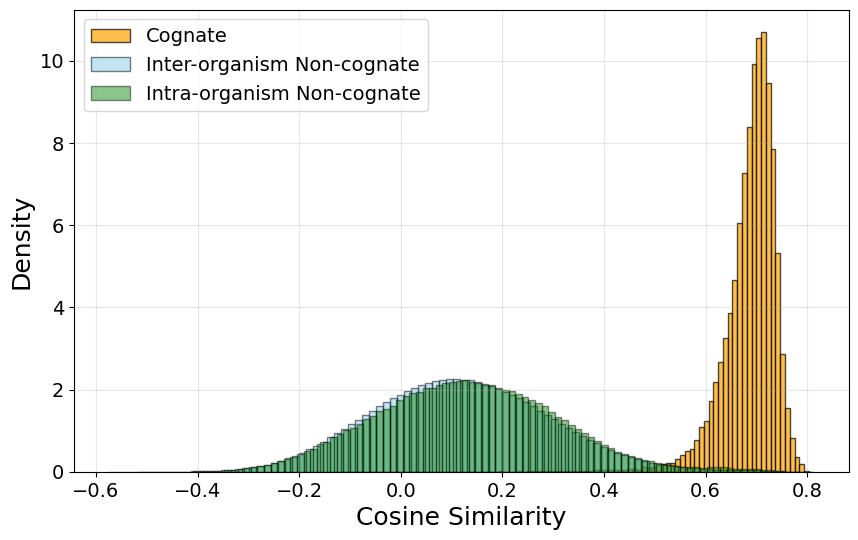

In [120]:
# Calculate and plot histograms of similarities for:
# - Cognate pairs (diagonal)
# - Non-cognate pairs (off-diagonal)
# - In organism non-cognate pairs (off-diagonal within organism)

print("Calculating and plotting histograms of similarities for cognate, non-cognate, and in-organism non-cognate pairs...")

in_organism_noncognate_mask = (org_equal_mask_all) & (~cognate_mask_all)
ex_organism_noncognate_mask = ~in_organism_noncognate_mask & ~cognate_mask_all

cognate_similarities = similarity_matrix_all[cognate_mask_all]
ex_organism_noncognate_similarities = similarity_matrix_all[ex_organism_noncognate_mask]
in_organism_noncognate_similarities = similarity_matrix_all[in_organism_noncognate_mask]

# Plot combined histogram for all three categories
plt.figure(figsize=(10, 6))
plt.hist(cognate_similarities, bins=100, density=True, alpha=0.7, color='orange', edgecolor='black', label='Cognate')
plt.hist(ex_organism_noncognate_similarities, bins=100, density=True, alpha=0.5, color='skyblue', edgecolor='black', label='Inter-organism Non-cognate')
plt.hist(in_organism_noncognate_similarities, bins=100, density=True, alpha=0.45, color='green', edgecolor='black', label='Intra-organism Non-cognate')
plt.xlabel('Cosine Similarity', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('Density', fontsize=18)
plt.yticks(fontsize=14)
# plt.title('Distribution of Cosine Similarities: Cognate, Non-cognate, and In-organism Non-cognate Pairs (Test Set)')
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)

plt.savefig("Similarity_Distribution_All.png", dpi=300, bbox_inches="tight")

plt.show()

#### Organism pair cross-talk similarity

In [34]:
def calculate_organism_pair_cross_talk_similarity(
    similarity_matrix,
    cognate_mask,
    promiscuous_mask,
    organism_names,
    homologous_cross_mask=None,
):

    # Normalize inputs
    similarity_matrix = np.asarray(similarity_matrix)
    cognate_mask = np.asarray(cognate_mask, dtype=bool)
    promiscuous_mask = np.asarray(promiscuous_mask, dtype=bool)

    if homologous_cross_mask is None:
        homologous_cross_mask = np.zeros_like(cognate_mask, dtype=bool)
    else:
        homologous_cross_mask = np.asarray(homologous_cross_mask, dtype=bool)

    organism_names = np.asarray(organism_names)
    N = similarity_matrix.shape[0]

    if similarity_matrix.shape != (N, N):
        raise ValueError("similarity_matrix must be square")
    if cognate_mask.shape != (N, N) or promiscuous_mask.shape != (N, N):
        raise ValueError("mask shapes must match similarity_matrix")

    non_cross_talk_mask = cognate_mask | promiscuous_mask | homologous_cross_mask
    cross_talk_mask = ~non_cross_talk_mask

    unique_organisms, organism_ids = np.unique(organism_names, return_inverse=True)
    n_orgs = len(unique_organisms)
    org_sample_counts = np.bincount(organism_ids, minlength=n_orgs)
    org_indices = {org: np.flatnonzero(organism_ids == idx) for idx, org in enumerate(unique_organisms)}

    results_cross_talk = []
    results_non_cross_talk = []

    total_pairs = n_orgs * (n_orgs + 1) // 2
    with tqdm(total=total_pairs, desc="Organism pairs") as progress:
        for idx1 in range(n_orgs):
            rows = org_indices[unique_organisms[idx1]]
            for idx2 in range(idx1, n_orgs):
                cols = org_indices[unique_organisms[idx2]]

                block_sim = similarity_matrix[np.ix_(rows, cols)]
                block_cross_mask = cross_talk_mask[np.ix_(rows, cols)]
                block_non_cross_mask = non_cross_talk_mask[np.ix_(rows, cols)]

                if idx1 == idx2:
                    dedup_mask = np.triu(np.ones_like(block_sim, dtype=bool))
                else:
                    dedup_mask = np.ones_like(block_sim, dtype=bool)

                # Cross-talk stats
                cross_vals = block_sim[block_cross_mask & dedup_mask]
                if cross_vals.size:
                    results_cross_talk.append(
                        {
                            "organism1": unique_organisms[idx1],
                            "organism2": unique_organisms[idx2],
                            "mean_cross_talk_similarity": cross_vals.mean(),
                            "n_pairs": cross_vals.size,
                            "n_samples1": org_sample_counts[idx1],
                            "n_samples2": org_sample_counts[idx2],
                        }
                    )

                # Non cross-talk stats (cognate/promiscuous/homologous)
                non_cross_vals = block_sim[block_non_cross_mask & dedup_mask]
                if non_cross_vals.size:
                    results_non_cross_talk.append(
                        {
                            "organism1": unique_organisms[idx1],
                            "organism2": unique_organisms[idx2],
                            "mean_non_cross_talk_similarity": non_cross_vals.mean(),
                            "n_pairs": non_cross_vals.size,
                            "n_samples1": org_sample_counts[idx1],
                            "n_samples2": org_sample_counts[idx2],
                        }
                    )

                progress.update(1)

    cross_talk_df = pd.DataFrame(results_cross_talk)
    non_cross_talk_df = pd.DataFrame(results_non_cross_talk)

    print(
        f"Completed cross-talk analysis for {len(cross_talk_df)} organism pairs "
        "(including same-organism pairs, cognate/promiscuous positions excluded)"
    )
    print(
        f"Completed non-cross-talk analysis for {len(non_cross_talk_df)} organism pairs "
        "(including same-organism pairs, cognate/promiscuous positions excluded)"
    )

    return cross_talk_df, non_cross_talk_df


# # Usage stays the same:
# cross_talk_org_similarity_all, non_cross_talk_org_similarity_all = calculate_organism_pair_cross_talk_similarity(
#     similarity_matrix_all,
#     cognate_mask_all,
#     promiscuous_mask_all,
#     tcs_organism_names_all,
#     homologous_cross_mask,
# )

# # Save results
# cross_talk_org_similarity_all.to_csv(DATA_PATH / 'cross_talk_similarities' / 'organism_pair_cross_talk_similarities.csv', index=False)
# non_cross_talk_org_similarity_all.to_csv(DATA_PATH / 'cross_talk_similarities' / 'organism_pair_non_cross_talk_similarities.csv', index=False)

# Load results
cross_talk_org_similarity_all = pd.read_csv(DATA_PATH / 'cross_talk_similarities' / 'organism_pair_cross_talk_similarities.csv')
non_cross_talk_org_similarity_all = pd.read_csv(DATA_PATH / 'cross_talk_similarities' / 'organism_pair_non_cross_talk_similarities.csv')

cross_talk_org_similarity_test = pd.read_pickle(DATA_PATH / 'cross_talk_similarities' / 'test_organism_pairwise_similarity_vs_distance.pkl')

In [35]:
non_cross_talk_org_similarity_all

organism1  \
0                       Acaryochloris_marina_MBIC11017   
1                       Acaryochloris_marina_MBIC11017   
2                       Acaryochloris_marina_MBIC11017   
3                       Acaryochloris_marina_MBIC11017   
4                       Acaryochloris_marina_MBIC11017   
...                                                ...   
183055              butyrate-producing_bacterium_SSC/2   
183056    candidate_division_SR1_bacterium_RAAC1_SR1_1   
183057  candidate_division_WWE3_bacterium_RAAC2_WWE3_1   
183058                      gamma_proteobacterium_HdN1   
183059            uncultured_Sulfuricurvum_sp._RIFRC-1   

                                             organism2  \
0                       Acaryochloris_marina_MBIC11017   
1            Acidithiobacillus_ferrooxidans_ATCC_23270   
2           Acidovorax_avenae_subsp._avenae_ATCC_19860   
3                          Acidovorax_citrulli_AAC00-1   
4                       Acinetobacter_baumannii_AB0057   
...                                                ...   
183055              butyrate-producing_bacterium_SSC/2   
183056    candidate_division_SR1_bacterium_RAAC1_SR1_1   
183057  candidate_division_WWE3_bacterium_RAAC2_WWE3_1   
183058                      gamma_proteobacterium_HdN1   
183059            uncultured_Sulfuricurvum_sp._RIFRC-1   

        mean_non_cross_talk_similarity  n_pairs  n_samples1  n_samples2  
0                             0.636772       47          34          34  
1                             0.114723        1          34          11  
2                            -0.168387        1          34          39  
3                             0.187979        1          34          28  
4                             0.541002        1          34          13  
...                                ...      ...         ...         ...  
183055                        0.682622       12          12          12  
183056                        0.595818        1           1           1  
183057                        0.599019        1           1           1  
183058                        0.657159       17          17          17  
183059                        0.642368       35          26          26  

[183060 rows x 6 columns]

#### Organism similarity Vs. Phylogeny

In [ ]:
def expand_organism_distance_matrix(
    similarity_matrix,
    organism_names,
    distance_mat_df,
):
    """
    Expand the distance matrix according to organism multiplicity in the similarity matrix.
    Uses vectorized operations for efficiency.

    Args:
        similarity_matrix: np.ndarray or torch.Tensor of shape [N, N] - cosine similarity matrix (precomputed)
        organism_names: list/np.ndarray of shape [N] - organism name for each pair (string, NOT formatted with _)
        distance_mat_df: DataFrame of phylogenetic distances, rows/columns are formatted organism names (spaces replaced with '_')

    Returns:
        np.ndarray: Expanded distance matrix of shape [N, N] where each element [i, j] is the distance 
                   between organism_names[i] and organism_names[j]
    """
    if distance_mat_df is None or similarity_matrix is None:
        raise ValueError("Required data structures not available")
    print("Required data structures validated")

    # Use np.array for all matrix operations for consistency
    if hasattr(similarity_matrix, "detach"):  # torch.Tensor
        similarity_matrix = similarity_matrix.detach().cpu().numpy()

    N = similarity_matrix.shape[0]
    
    # Format organism names for distance matrix lookup
    organism_names_formatted = np.array([o.replace(' ', '_') for o in organism_names])
    unique_organisms = np.unique(organism_names)
    unique_organisms_formatted = [o.replace(' ', '_') for o in unique_organisms]
    organisms_in_common = list(set(unique_organisms_formatted) & set(distance_mat_df.index))

    if len(organisms_in_common) == 0:
        raise ValueError("No organisms from embeddings are found in distance matrix")

    testset_distance_subset = distance_mat_df.loc[organisms_in_common, organisms_in_common].copy()
    print(f"Found {len(organisms_in_common)} organisms in common between datasets")

    # Convert distance subset to numpy array for fast indexing
    distance_mat = testset_distance_subset.values
    organisms_in_common_array = np.array(organisms_in_common)
    
    # Create mapping from formatted organism name to index in distance matrix
    org_to_idx = {org: idx for idx, org in enumerate(organisms_in_common)}
    
    # Create mask for organisms that are in the distance matrix
    valid_org_mask = np.array([org in organisms_in_common for org in organism_names_formatted])
    
    # Get indices in distance matrix for each element in organism_names_formatted
    # Use -1 as sentinel for organisms not in distance matrix
    org_indices_in_dist_mat = np.array([org_to_idx.get(org, -1) for org in organism_names_formatted])
    
    # Create meshgrid of all pairs (i, j)
    i_indices, j_indices = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
    
    # Get corresponding organism indices in distance matrix for all pairs
    i_org_indices = org_indices_in_dist_mat[i_indices]
    j_org_indices = org_indices_in_dist_mat[j_indices]
    
    # Create mask for valid pairs (both organisms are in distance matrix)
    valid_pair_mask = (i_org_indices >= 0) & (j_org_indices >= 0)
    
    # Initialize expanded distance matrix with NaN
    expanded_distance_matrix = np.full((N, N), np.nan, dtype=np.float64)
    
    # Vectorized distance lookup for valid pairs
    valid_i = i_org_indices[valid_pair_mask]
    valid_j = j_org_indices[valid_pair_mask]
    valid_distances = distance_mat[valid_i, valid_j]
    
    # Filter out invalid distances (-1, inf, nan)
    invalid_dist_mask = (valid_distances == -1) | np.isinf(valid_distances) | np.isnan(valid_distances)
    valid_distances[invalid_dist_mask] = np.nan
    
    # Assign valid distances to the expanded matrix
    expanded_distance_matrix[valid_pair_mask] = valid_distances
    
    print("Distance matrix expansion complete")
    valid_count = np.sum(~np.isnan(expanded_distance_matrix))
    print(f"Valid distances assigned: {valid_count} out of {N*N} total elements")
    
    return expanded_distance_matrix


# EXAMPLE USAGE:
# You need to provide organism_names (list or np.ndarray, length = N)
# and proximity_groups (list or np.ndarray, length = N) corresponding to the original test set order.
# Example:
# organism_names = test_df['organism'].tolist()
# proximity_groups = test_df['proximity_group'].tolist()

expanded_distance_matrix = expand_organism_distance_matrix(
    similarity_matrix,
    tcs_organism_names,
    distance_mat_df,
)

# # Optional: Save results
# np.save(DATA_PATH / 'expanded_distance_matrix.npy'), expanded_distance_matrix)

Required data structures validated
Found 100 organisms in common between datasets
Distance matrix expansion complete
Valid distances assigned: 3553225 out of 4443664 total elements


In [ ]:
# The following code avoids huge memory allocation by iterating in chunks through valid indices
# rather than masking a (N,N) matrix of >10M elements into 1D arrays at once.

# Get indices for valid pairs for both cognate and non-cognate, using numpy.where (returns (i,j))
non_cognate_indices = np.where((~cognate_mask) & valid_distance_mask & tril_mask)
cognate_indices = np.where(cognate_mask & valid_distance_mask & tril_mask)

def batch_scatter_plot(x_source, y_source, batch_size=500_000, **scatter_kwargs):
    """Scatter plot points in batches to avoid memory spikes."""
    N_points = x_source.shape[0]
    for start in range(0, N_points, batch_size):
        end = min(start + batch_size, N_points)
        plt.scatter(
            x_source[start:end], y_source[start:end],
            **scatter_kwargs
        )
        gc.collect()  # release memory for large slices

# Extract x and y for non-cognate pairs in chunks
x_non_cognate = expanded_distance_matrix[non_cognate_indices]
y_non_cognate = similarity_matrix[non_cognate_indices]

# Extract x and y for cognate pairs
x_cognate = expanded_distance_matrix[cognate_indices]
y_cognate = similarity_matrix[cognate_indices]

plt.figure(figsize=(10, 6))

if x_non_cognate.size > 0 and y_non_cognate.size > 0:
    if x_non_cognate.size > 2:
        # Use density estimate, but operate in batches if possible
        # Otherwise, random sub-sample if it's huge
        if x_non_cognate.size > 2_000_000:
            rng = np.random.default_rng(42)
            idx = rng.choice(x_non_cognate.size, size=500_000, replace=False)
            x_non_cognate_sub = x_non_cognate[idx]
            y_non_cognate_sub = y_non_cognate[idx]
        else:
            x_non_cognate_sub = x_non_cognate
            y_non_cognate_sub = y_non_cognate

        xy = np.vstack([x_non_cognate_sub, y_non_cognate_sub])
        z = gaussian_kde(xy)(xy) if x_non_cognate_sub.size > 2 else np.ones_like(x_non_cognate_sub)
        idx_sort = z.argsort()
        x_sorted, y_sorted, z_sorted = x_non_cognate_sub[idx_sort], y_non_cognate_sub[idx_sort], z[idx_sort]

        plt.scatter(
            x_sorted, y_sorted,
            c=z_sorted, s=10, cmap='viridis', alpha=0.6, label='Non-Cognate Pairs'
        )
    else:
        # Too few points to bother with density
        batch_scatter_plot(x_non_cognate, y_non_cognate, s=10, alpha=0.6, color='blue', label='Non-Cognate Pairs')

if x_cognate.size > 0 and y_cognate.size > 0:
    batch_scatter_plot(x_cognate, y_cognate, s=10, alpha=0.5, color='goldenrod', label='Cognate Pairs')

# LOESS line for non-cognate pairs (subsample if too big)
if x_non_cognate.size > 2:
    import pandas as pd
    if x_non_cognate.size > 200_000:
        rng = np.random.default_rng(123)
        id_loess = rng.choice(x_non_cognate.size, size=200_000, replace=False)
        df_non_cognate = pd.DataFrame({
            'distance': x_non_cognate[id_loess],
            'mean_similarity': y_non_cognate[id_loess]
        })
    else:
        df_non_cognate = pd.DataFrame({'distance': x_non_cognate, 'mean_similarity': y_non_cognate})
    import seaborn as sns
    sns.regplot(
        x='distance', y='mean_similarity', data=df_non_cognate,
        scatter=False, lowess=True, color='red', line_kws={'linewidth': 2}
    )
    del df_non_cognate

plt.legend()
plt.xlabel('Organism Pair Kmer Distance (0<->1)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('HK-RR Mean Similarity\n(point = organism pair)', fontsize=16)
plt.grid(True, alpha=0.3)

# Only show density colorbar if density was used (will be on large non-cognate)
if x_non_cognate.size > 2:
    mappable = plt.scatter([], [], c=[], cmap='viridis')
    plt.colorbar(label='Local density')

plt.show()

/tmp/ipykernel_2253549/3951042180.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  non_cognate_indices = np.where((~cognate_mask) & valid_distance_mask & tril_mask)
/tmp/ipykernel_2253549/3951042180.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cognate_indices = np.where(cognate_mask & valid_distance_mask & tril_mask)


#### Organism similarity Vs. Taxonomy

##### Taxonomy LCA

In [28]:
# group organism pairs by lowest common taxonomic level
def load_distance_matrix(file_path):
    """Load and clean a distance matrix from CSV."""
    df = pd.read_csv(file_path, index_col=0)
    
    # Clean the matrix (remove any NaN/inf values)
    df = df.fillna(1.0)  # Fill NaN with maximum distance
    df = df.replace([np.inf, -np.inf], 1.0)  # Replace infinite values
    
    # Ensure matrix is symmetric
    df = (df + df.T) / 2
    
    # Set diagonal to zero (distance from genome to itself)
    np.fill_diagonal(df.values, 0)
    
    return df


def find_lowest_common_ancestor(org1_tax, org2_tax, taxonomy_levels):
    """
    Find the lowest common ancestor (most specific shared taxonomic level) between two organisms.
    
    Parameters:
    -----------
    org1_tax : dict
        Taxonomy dictionary for organism 1
    org2_tax : dict
        Taxonomy dictionary for organism 2
    taxonomy_levels : list
        List of taxonomic levels from least to most specific
        
    Returns:
    --------
    str or None
        The lowest common ancestor taxonomic level, or None if no common ancestor found
    """
    # Start from most specific (strain) and go up to least specific (kingdom)
    for level in reversed(taxonomy_levels):
        val1 = org1_tax.get(level)
        val2 = org2_tax.get(level)
        
        # Check if both have values and they're not NaN and they match
        if (pd.notna(val1) and pd.notna(val2) and 
            str(val1) != '?' and str(val2) != '?' and
            str(val1) == str(val2)):
            return level
    return None


def get_organism_pairs_by_taxonomy(reference_k=15):
    """
    Identify organism pairs that share the same lowest common taxonomic level.
    This is invariant to distance matrix values - only depends on taxonomy.
    Includes same-organism pairs (diagonal).
    
    Parameters:
    -----------
    reference_k : int
        K value to use for loading a reference distance matrix (just to get organism names)
        
    Returns:
    --------
    pair_indices : list of tuples
        List of (i, j, lca_level) for pairs that share at least the same family
        Includes same-organism pairs (where i == j)
    org_names : list
        List of organism names (in order matching distance matrix indices)
    """
    # Load a reference distance matrix (any k value works - we just need organism names)
    file_path = data_dir / f"distance_matrix_k{reference_k}.csv"
    if not file_path.exists():
        print(f"Reference file not found: {file_path}")
        return None, None
    
    print(f"Loading reference distance matrix (k={reference_k}) to get organism names...")
    distance_matrix = load_distance_matrix(file_path)
    
    # Load taxonomy data
    if 'organism_taxonomy_df' not in locals():
        print("Loading taxonomy data...")
        organism_taxonomy_df = pd.read_csv(taxonomy_dir / "organism_taxonomy.csv")
    
    # Define taxonomic levels (from least to most specific)
    taxonomy_levels = [
        'kingdom',
        'phylum',
        'class',
        'order',
        'family',
        'genus',
        'species',
        'subspecies',
        'strain'
    ]
    
    # Set up taxonomy lookup
    taxonomy_lookup = organism_taxonomy_df.set_index('organism_name')
    
    # Get all organism names from distance matrix
    org_names = list(distance_matrix.index)
    
    # Build taxonomy dictionaries for all organisms (pre-process for efficiency)
    org_taxonomies = {}
    taxonomy_fallback = {}  # For fallback matching
    
    # Pre-build fallback mapping
    for idx in taxonomy_lookup.index:
        normalized_key = str(idx).replace("_", " ")
        if normalized_key not in taxonomy_fallback:
            taxonomy_fallback[normalized_key] = idx
    
    print("Building taxonomy dictionaries...")
    for org in org_names:
        if org in taxonomy_lookup.index:
            row = taxonomy_lookup.loc[org]
            org_taxonomies[org] = {level: row.get(level, '?') for level in taxonomy_levels}
        else:
            # Try fallback matching
            org_normalized = org.replace("_", " ")
            if org_normalized in taxonomy_fallback:
                matching_org = taxonomy_fallback[org_normalized]
                row = taxonomy_lookup.loc[matching_org]
                org_taxonomies[org] = {level: row.get(level, '?') for level in taxonomy_levels}
            else:
                org_taxonomies[org] = {level: '?' for level in taxonomy_levels}
    
    # Collect pair indices and LCA levels for pairs that are at least in the same family
    # Format: list of tuples (i, j, lca_level)
    pair_data = []
    
    n_orgs = len(org_names)
    total_pairs = n_orgs * (n_orgs + 1) // 2  # Updated to include diagonal
    
    print(f"Processing {total_pairs:,} organism pairs (including same-organism pairs)...")
    print("Collecting all unique organism pairs (upper triangle including diagonal)...")
    
    for i in range(n_orgs):
        org1 = org_names[i]
        org1_tax = org_taxonomies[org1]
        
        # Include same-organism pairs (diagonal) and upper triangle
        for j in range(i, n_orgs):  # Changed from i+1 to i to include diagonal
            org2 = org_names[j]
            org2_tax = org_taxonomies[org2]
            
            # For same-organism pairs, find the most specific taxonomic level available
            if i == j:
                lca_level = 'strain'
            else:
                # For different organisms, find lowest common ancestor
                lca_level = find_lowest_common_ancestor(org1_tax, org2_tax, taxonomy_levels)
            
            # Include all pairs, regardless of LCA level
            pair_data.append((i, j, lca_level))
    
    print(f"\nFound {len(pair_data):,} pairs (including {n_orgs:,} same-organism pairs)")
    
    # Print breakdown by LCA level
    lca_counts = {}
    for _, _, lca_level in pair_data:
        lca_counts[lca_level] = lca_counts.get(lca_level, 0) + 1
    print("\nBreakdown by lowest common ancestor level:")
    for level in taxonomy_levels:
        if level in lca_counts:
            print(f"  {level}: {lca_counts[level]:,} pairs")
    
    return pair_data, org_names

# # Get organism pair data (indices + LCA levels, invariant to k)
# organism_pair_taxonomic_lca, ordered_unique_organisms = get_organism_pairs_by_taxonomy(reference_k=15)

# # save pair_data and org_names
# np.save(DATA_PATH / 'taxonomy' / 'pair_taxonomic_lca.npy', organism_pair_taxonomic_lca)
# np.save(DATA_PATH / 'taxonomy' / 'org_names.npy'), ordered_unique_organisms)

# load pair_data and org_names
organism_pair_taxonomic_lca = np.load(DATA_PATH / 'taxonomy' / 'pair_taxonomic_lca.npy', allow_pickle=True)
ordered_unique_organisms = np.load(DATA_PATH / 'taxonomy' / 'org_names.npy', allow_pickle=True)

##### Merge & Plot

In [36]:
def compute_pair_data_df(
    organism_pair_taxonomic_lca,
    distance_mat_df,
    cross_talk_similarities,
    non_cross_talk_similarities=None,
    cross_talk_colname = None,
    non_cross_talk_colname = None
):
    """
    Build two DataFrames keyed by (organism1, organism2):
    - cross-talk mean similarities merged onto the LCA info
    - non-cross-talk mean similarities merged onto the same LCA info
    """
    
    if cross_talk_colname is None:
        cross_talk_colname = "mean_cross_talk_similarity"
    if non_cross_talk_colname is None:
        non_cross_talk_colname = "mean_non_cross_talk_similarity"

    base_df = pd.DataFrame(
        organism_pair_taxonomic_lca, columns=["i", "j", "lca_level"]
    )

    index_list = list(distance_mat_df.index)
    base_df["organism1"] = base_df["i"].apply(lambda x: index_list[x])
    base_df["organism2"] = base_df["j"].apply(lambda x: index_list[x])
    base_df[["organism1", "organism2"]] = base_df[["organism1", "organism2"]].astype(str)

    cross_lookup = cross_talk_similarities[
        ["organism1", "organism2", cross_talk_colname]
    ].copy()
    cross_lookup[["organism1", "organism2"]] = cross_lookup[["organism1", "organism2"]].astype(str)

    cross_df = (
        base_df.merge(cross_lookup, on=["organism1", "organism2"], how="left")
        .dropna(subset=[cross_talk_colname])
        .reset_index(drop=True)
    )

    non_cross_df = None
    if non_cross_talk_similarities is not None:
        non_cross_lookup = non_cross_talk_similarities[
            ["organism1", "organism2", non_cross_talk_colname]
        ].copy()
        non_cross_lookup[["organism1", "organism2"]] = non_cross_lookup[
            ["organism1", "organism2"]
        ].astype(str)

        non_cross_df = (
            base_df.merge(non_cross_lookup, on=["organism1", "organism2"], how="left")
            .dropna(subset=[non_cross_talk_colname])
            .reset_index(drop=True)
        )

    cross_df = cross_df.rename(columns={cross_talk_colname: "mean_similarity"})
    if non_cross_df is not None:
        non_cross_df = non_cross_df.rename(columns={non_cross_talk_colname: "mean_similarity"})

    return cross_df, non_cross_df

# Calculate for 'all'
cross_talk_df_all, non_cross_talk_df_all = compute_pair_data_df(
    organism_pair_taxonomic_lca, 
    distance_mat_df, 
    cross_talk_org_similarity_all,
    non_cross_talk_org_similarity_all
)

# # Calculate for 'test'
cross_talk_df_test, non_cross_talk_df_test = compute_pair_data_df(
    organism_pair_taxonomic_lca, 
    distance_mat_df, 
    cross_talk_org_similarity_test,
    cross_talk_colname = "mean_similarity",
    # non_cross_talk_org_similarity_test
)

non_cross_talk_df_test = non_cross_talk_df_all

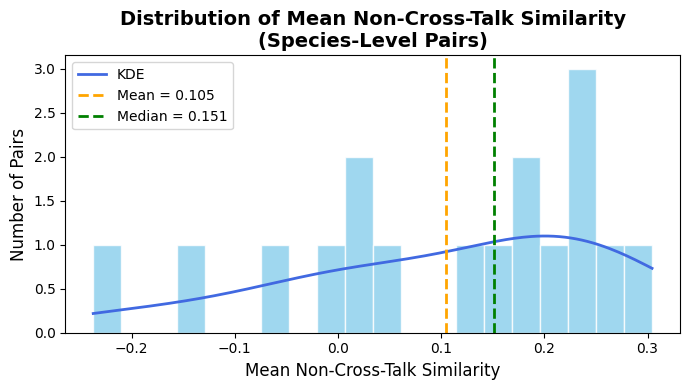

In [49]:
# Plot histogram for species-level mean_similarity from non-cross-talking pairs (no seaborn)

fig, ax = plt.subplots(figsize=(7, 4))
species_sim_values = non_cross_talk_df_test.loc[non_cross_talk_df_test['lca_level'] == 'subspecies', 'mean_similarity']

# Plot histogram
n, bins, patches = ax.hist(
    species_sim_values,
    bins=20,
    color="skyblue",
    edgecolor="white",
    alpha=0.8
)

# Optionally overlay a kernel density estimation using scipy.stats
try:
    from scipy.stats import gaussian_kde
    import numpy as np
    kde = gaussian_kde(species_sim_values)
    x_vals = np.linspace(species_sim_values.min(), species_sim_values.max(), 200)
    ax.plot(x_vals, kde(x_vals)*len(species_sim_values)*np.diff(bins)[0], color='royalblue', lw=2, label='KDE')
except ImportError:
    pass

mean_val = species_sim_values.mean()
median_val = species_sim_values.median()
ax.axvline(mean_val, color='orange', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.3f}")
ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f"Median = {median_val:.3f}")
ax.set_title("Distribution of Mean Non-Cross-Talk Similarity\n(Species-Level Pairs)", fontsize=14, weight='bold')
ax.set_xlabel("Mean Non-Cross-Talk Similarity", fontsize=12)
ax.set_ylabel("Number of Pairs", fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

In [53]:
cross_talk_df_test

i     j lca_level  \
0           0     0    strain   
1           0   433      None   
2           0   553   kingdom   
3           0   589      None   
4           0   630     class   
...       ...   ...       ...   
1015773  2127  2127    strain   
1015774  2128  2128    strain   
1015775  2128  2129    phylum   
1015776  2129  2129    strain   
1015777  2130  2130    strain   

                                                organism1  \
0                      Marinomonas_posidonica_IVIA-Po-181   
1                      Marinomonas_posidonica_IVIA-Po-181   
2                      Marinomonas_posidonica_IVIA-Po-181   
3                      Marinomonas_posidonica_IVIA-Po-181   
4                      Marinomonas_posidonica_IVIA-Po-181   
...                                                   ...   
1015773   Lactobacillus_plantarum_subsp._plantarum_ST-III   
1015774  Streptococcus_constellatus_subsp._pharyngis_C232   
1015775  Streptococcus_constellatus_subsp._pharyngis_C232   
1015776                      Veillonella_parvula_DSM_2008   
1015777          Carboxydothermus_hydrogenoformans_Z-2901   

                                                organism2  mean_similarity  
0                      Marinomonas_posidonica_IVIA-Po-181         0.151826  
1                          Dehalococcoides_mccartyi_DCMB5         0.156194  
2                  Campylobacter_fetus_subsp._fetus_82-40         0.174594  
3                         Corynebacterium_glutamicum_K051         0.130894  
4                                  Yersinia_pestis_KIM10+         0.160200  
...                                                   ...              ...  
1015773   Lactobacillus_plantarum_subsp._plantarum_ST-III         0.106702  
1015774  Streptococcus_constellatus_subsp._pharyngis_C232         0.088543  
1015775                      Veillonella_parvula_DSM_2008         0.133026  
1015776                      Veillonella_parvula_DSM_2008         0.159452  
1015777          Carboxydothermus_hydrogenoformans_Z-2901         0.195994  

[1015778 rows x 6 columns]

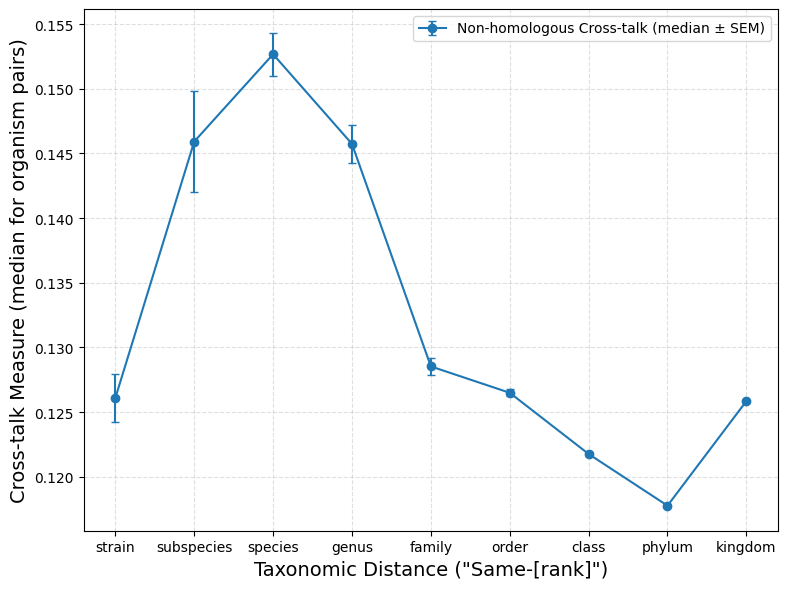

In [52]:
# plot mean similarity vs. taxonomic level

# Calculate mean and standard error of similarity for each taxonomic (lca) level
# For 'strain' use pair_data_df_test, for all other levels use pair_data_df
cross_talk_agg_main = cross_talk_df_test.groupby('lca_level')['mean_similarity'].agg(['median', 'std', 'count']).reset_index()
cross_talk_agg_main['sem'] = cross_talk_agg_main['std'] / np.sqrt(cross_talk_agg_main['count'])
non_cross_talk_agg_main = non_cross_talk_df_test.groupby('lca_level')['mean_similarity'].agg(['median', 'std', 'count']).reset_index()
non_cross_talk_agg_main['sem'] = non_cross_talk_agg_main['std'] / np.sqrt(non_cross_talk_agg_main['count'])


cross_talk_agg_strain = cross_talk_df_test.groupby('lca_level')['mean_similarity'].agg(['median', 'std', 'count']).reset_index()
cross_talk_agg_strain['sem'] = cross_talk_agg_strain['std'] / np.sqrt(cross_talk_agg_strain['count'])
non_cross_talk_agg_strain = non_cross_talk_df_test.groupby('lca_level')['mean_similarity'].agg(['median', 'std', 'count']).reset_index()
non_cross_talk_agg_strain['sem'] = non_cross_talk_agg_strain['std'] / np.sqrt(non_cross_talk_agg_strain['count'])
# agg_strain = pair_data_df_test.groupby('lca_level')['mean_cross_talk_similarity'].agg(['mean', 'std', 'count']).reset_index()
# agg_strain['sem'] = agg_strain['std'] / np.sqrt(agg_strain['count'])

level_order = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'subspecies', 'strain'][::-1]

cross_talk_agg_main = cross_talk_agg_main.set_index('lca_level')
cross_talk_agg_strain = cross_talk_agg_strain.set_index('lca_level')
non_cross_talk_agg_main = non_cross_talk_agg_main.set_index('lca_level')
non_cross_talk_agg_strain = non_cross_talk_agg_strain.set_index('lca_level')

# Compose ordered dataframes so 'strain' comes from *_strain, everything else from *_main
def compose_ordered_agg_df(agg_main, agg_strain, level_order):
    # Compose a DataFrame with the right order, using 'strain' from agg_strain and others from agg_main
    rows = []
    for lvl in level_order:
        if lvl == 'strain' and lvl in agg_strain.index:
            row = agg_strain.loc[lvl].copy()
            row['lca_level'] = lvl
            rows.append(row)
        elif lvl in agg_main.index:
            row = agg_main.loc[lvl].copy()
            row['lca_level'] = lvl
            rows.append(row)
    agg_ordered = pd.DataFrame(rows)
    # Order index and return
    present_levels = [l for l in level_order if l in agg_ordered['lca_level'].values]
    agg_ordered = agg_ordered.set_index('lca_level').reindex(present_levels).reset_index()
    return agg_ordered, present_levels

cross_talk_agg_ordered, present_levels = compose_ordered_agg_df(cross_talk_agg_main, cross_talk_agg_strain, level_order)
non_cross_talk_agg_ordered, _ = compose_ordered_agg_df(non_cross_talk_agg_main, non_cross_talk_agg_strain, level_order)

plt.figure(figsize=(8, 6))

plt.errorbar(
    cross_talk_agg_ordered['lca_level'],
    cross_talk_agg_ordered['median'],
    yerr=cross_talk_agg_ordered['sem'],
    fmt='o-', capsize=3,
    color='tab:blue',
    label='Non-homologous Cross-talk (median ± SEM)'
)
# plt.errorbar(
#     non_cross_talk_agg_ordered['lca_level'],
#     non_cross_talk_agg_ordered['median'],
#     yerr=non_cross_talk_agg_ordered['sem'],
#     fmt='o-', capsize=3,
#     color='tab:orange',
#     label='Homologous Cross-talk (median ± SEM)'
# )
plt.xticks(present_levels)
plt.xlabel('Taxonomic Distance ("Same-[rank]")', fontsize=14)
plt.ylabel('Cross-talk Measure (median for organism pairs)', fontsize=14)
# plt.title('Mean HK-RR Embedding Similarity vs. Taxonomic Distance')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.legend()
# plt.savefig('mean_similarity_vs_taxonomic_level_with_non_cross_talk.png')
plt.show()


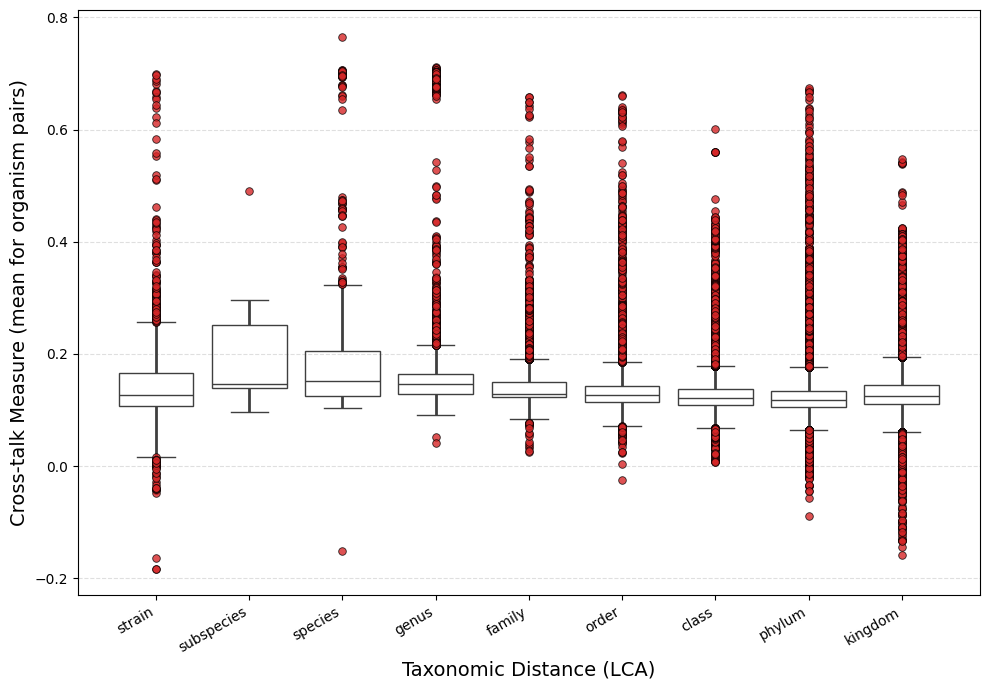

In [47]:
# Boxplot with scatter (stripplot with jitter) for mean similarity vs. taxonomic level
# Sample a subset of points for the scatter

level_order = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'subspecies', 'strain'][::-1]
present_levels = [l for l in level_order if l in cross_talk_df_test['lca_level'].unique()]

# Make sure lca_level is a categorical with specified order
plot_df = cross_talk_df_test.copy()
plot_df['lca_level'] = pd.Categorical(plot_df['lca_level'], categories=present_levels, ordered=True)

plt.figure(figsize=(10, 7))

# Boxplot
sns.boxplot(
    x='lca_level', 
    y='mean_similarity', 
    data=plot_df, 
    order=present_levels, 
    showcaps=True, 
    boxprops={'facecolor':'None'}, 
    showfliers=False,
    whiskerprops={'linewidth':2}
)

# Show all outliers for each boxplot, colored as points over the boxplot

# Compute boxplot statistics per group manually
import matplotlib.patheffects as pe

for i, level in enumerate(present_levels):
    vals = plot_df.loc[plot_df['lca_level'] == level, 'mean_similarity']
    if len(vals) == 0:
        continue
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = vals[(vals < lower_bound) | (vals > upper_bound)]
    plt.scatter(
        np.full(outliers.shape, i),  # x position
        outliers,
        color='tab:red',
        s=30,
        alpha=0.8,
        zorder=10,
        edgecolor='black',
        linewidth=0.6,
        label='Outliers' if i == 0 else ""  # Only one legend entry
    )


plt.xlabel('Taxonomic Distance (LCA)', fontsize=14)
plt.ylabel('Cross-talk Measure (mean for organism pairs)', fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
# plt.savefig('mean_similarity_vs_taxonomic_level_boxplot.png')

plt.show()


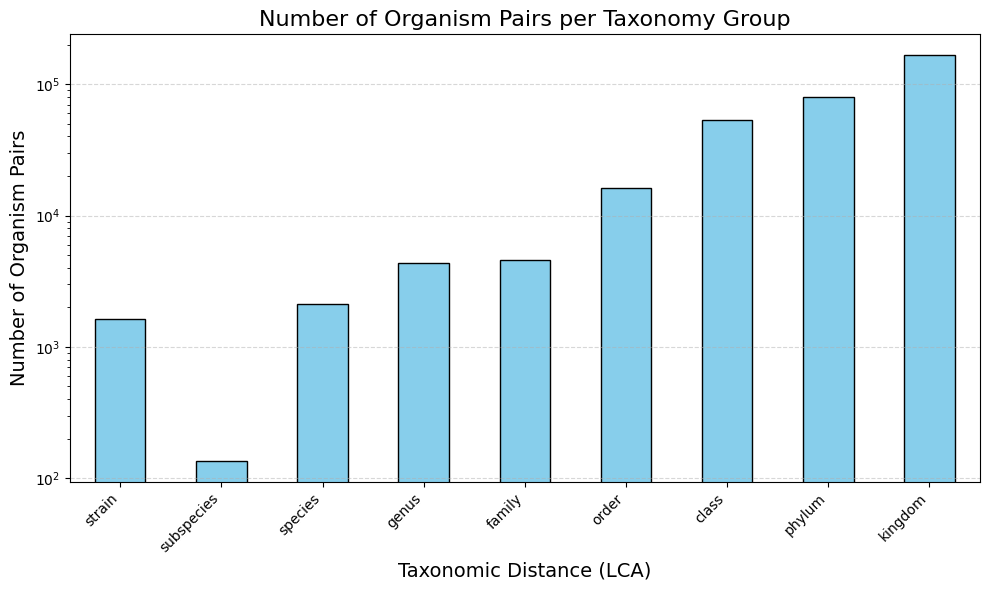

In [32]:
# Plot histogram showing the amount (count) from each taxonomy group

plt.figure(figsize=(10, 6))
taxonomy_counts = pair_data_df['lca_level'].value_counts().reindex(level_order, fill_value=0)
taxonomy_counts = taxonomy_counts[taxonomy_counts > 0]  # Only plot levels present in data

taxonomy_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Taxonomic Distance (LCA)', fontsize=14)
plt.ylabel('Number of Organism Pairs', fontsize=14)
plt.title('Number of Organism Pairs per Taxonomy Group', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('taxonomy_group_histogram.png')
plt.show()


#### Validate Wet Results

##### Marginal Specificity in TCS

In [50]:
groups_df = pd.read_pickle("/zdata/user-data/noam/data/p2cs/merged_p2cs_data/p2cs_filtered_groups.pkl")

In [58]:
"LADDRTLLMAGVSHDLRTPLTRIRLATEMMSEQDGYLAESINKDIEECNAIIEQFIDYLR" in groups_df.loc[groups_df['Gene'] == 'Y75_p3772', 'aa_sequence'].values[0]

True

**sp511145_1 is in Y75_p3772. So that is what they used in the paper!**

We now prepare the mutation data for the paper.

In [85]:
fasta_path = marginal_specificity_dir / "pnas.2221163120.sd11.txt"

# Read both fasta identifiers and sequences, then pair them correctly
entry_ids = []
sequences = []
with open(fasta_path, "r") as f:
    seq = ""
    for line in f:
        line = line.strip()
        if line.startswith(">"):
            if seq:
                sequences.append(seq)
                seq = ""
            entry_ids.append(line[1:])  # Remove '>'
        else:
            seq += line
    if seq:
        sequences.append(seq)

mutated_dhps = pd.DataFrame({"entry_id": entry_ids, "sequence": sequences})

enz_sequence = groups_df.loc[groups_df['Gene'] == 'Y75_p3772', 'aa_sequence'].values[0]
dhp_start = enz_sequence.find(mutated_dhps.loc[0, 'sequence'])
dhp_end = dhp_start + len(mutated_dhps.loc[0, 'sequence'])

mutated_envZs = mutated_dhps.apply(lambda row: enz_sequence[:dhp_start] + row['sequence'] + enz_sequence[dhp_end:], axis=1)

mutated_envZs_df = pd.DataFrame({'aa_sequence': mutated_envZs})

In [ ]:
# mutated_envZs_df.to_pickle(marginal_specificity_dir / "mutated_envZs.pkl")

In [ ]:
# Compute Hamming distance from the first row's aa_sequence
def hamming_distance(seq1, seq2):
    # Assumes equal length sequences
    return sum(a != b for a, b in zip(seq1, seq2))

reference_seq = mutated_envZs_df.iloc[0]['aa_sequence']
mutated_envZs_df['hamming_distance_from_first'] = mutated_envZs_df['aa_sequence'].apply(lambda seq: hamming_distance(seq, reference_seq))
mutated_envZs_df

**Now we embed the mutated envZs with ESM3 and continue**

In [202]:
np.array(all_df.loc[all_df['hk_gene'] == 'Y75_p3772', 'hk_embedding'].values[0])

array([ 0.00637223,  0.0368975 , -0.03502563, ..., -0.04174778,
       -0.02709742, -0.01112987], shape=(2560,))

In [203]:
mutated_envZs_embeddings[0]

array([ 0.00616233,  0.03682855, -0.03496726, ..., -0.04170797,
       -0.02632003, -0.01174795], shape=(2560,), dtype=float32)

In [204]:
mutated_envZs_embeddings = np.load(base_dir / "embeddings" / "esm3-medium" / "all_embeddings" / "mutated_envZs_mean_embeddings_esm3-medium-2024-08.npy")

np.allclose(mutated_envZs_embeddings[0], all_df.loc[all_df['hk_gene'] == 'Y75_p3772', 'hk_embedding'].values[0])

False

In [198]:
mutated_envZs_embeddings = np.load(base_dir / "embeddings" / "esm3-medium" / "all_embeddings" / "mutated_envZs_mean_embeddings_esm3-medium-2024-08.npy")

assert(mutated_envZs_embeddings[0] == all_df.loc[all_df['hk_gene'] == 'Y75_p3772', 'hk_embedding'].values[0])

# scale the mutated envZs embeddings with train mean and std
mutated_envZs_scaled_embeddings = (mutated_envZs_embeddings - hk_train_mean) / (hk_train_std + 1e-8)

# project the mutated envZs embeddings to the shared embedding space
mutated_envZs_projected_embeddings = project_single_head_embeddings(model, mutated_envZs_scaled_embeddings, 'HK', DEVICE)

# # get the projected embedding of the OmpR
# ompr_index = all_df.index[all_df['rr_gene'] == 'Y75_p3771']
# ompr_projected_embedding = rr_all_embeddings[ompr_index]
# envz_wt_index = all_df.index[all_df['hk_gene'] == 'Y75_p3772']
# envz_wt_projected_embedding = hk_all_embeddings[envz_wt_index]

# # Ensure both arrays are contiguous and have correct dtype for np.dot
# mutated_envZs_projected_embeddings = np.ascontiguousarray(mutated_envZs_projected_embeddings, dtype=np.float32)
# ompr_projected_embedding = np.ascontiguousarray(ompr_projected_embedding, dtype=np.float32)

# # Compute the similarity matrix between the mutated envZs and the OmpR
# similarity_matrix = np.dot(mutated_envZs_projected_embeddings, ompr_projected_embedding.T)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [190]:
hk_all_embeddings[envz_wt_index]

tensor([[-0.0803, -0.0857, -0.0056, -0.2116, -0.0237,  0.0805, -0.0623, -0.1427,
          0.0091, -0.0787, -0.0176, -0.1046, -0.0287, -0.1871,  0.0095,  0.1658,
         -0.1520,  0.0144, -0.0550, -0.1075,  0.0204, -0.0312, -0.0520, -0.0230,
         -0.0086, -0.0638,  0.0855,  0.0505,  0.0861, -0.0464, -0.0221, -0.0793,
          0.1264,  0.0207,  0.1030, -0.0481,  0.0354,  0.0640,  0.0215, -0.0191,
          0.1267,  0.0856, -0.1160,  0.0154, -0.0033, -0.0685, -0.0440,  0.0879,
          0.0465,  0.0185,  0.0104,  0.0620,  0.0072, -0.0595, -0.0014, -0.0594,
         -0.1590,  0.0729,  0.1100,  0.0086,  0.0670,  0.0007,  0.0017, -0.1128,
         -0.1234, -0.0453, -0.0329,  0.1824, -0.0839,  0.1146,  0.0548, -0.1739,
          0.1391,  0.1532, -0.0852,  0.0232, -0.1943, -0.1426,  0.1784,  0.0109,
         -0.0692,  0.0971, -0.1065,  0.0240, -0.0288,  0.1670, -0.0067, -0.0567,
          0.0618,  0.1369,  0.0381,  0.1639,  0.0322, -0.0207,  0.0331, -0.0286,
         -0.0227,  0.0874, -

In [197]:
mutated_envZs_projected_embeddings[0]

array([-0.15659347,  0.07997736,  0.04484887,  0.09059158,  0.14153409,
       -0.06632441,  0.01910153,  0.0051861 ,  0.05616248, -0.01348547,
        0.04797081,  0.0840786 ,  0.05396397,  0.06839348,  0.0513827 ,
        0.18104272,  0.12478031, -0.24620551,  0.09987325, -0.03087262,
       -0.04021535, -0.02701433,  0.10827269, -0.04122216,  0.00730107,
       -0.05218658, -0.00638661,  0.04416309, -0.06050258, -0.15208504,
        0.08443384,  0.10783882,  0.10160897, -0.05999167, -0.0064844 ,
       -0.0496706 ,  0.02111083, -0.04352469, -0.08505782,  0.16546476,
       -0.03034604, -0.05093805, -0.02300017, -0.03129654,  0.03171623,
        0.02385631, -0.18370436,  0.09716778,  0.04034785, -0.12864366,
        0.01850269, -0.15824226, -0.09511822, -0.14783667,  0.06835027,
       -0.05243387, -0.00827809, -0.00396781,  0.03187273, -0.05919116,
       -0.16325279,  0.04342033, -0.03963387,  0.07930455, -0.00706408,
       -0.02642448,  0.11118932, -0.1068688 ,  0.11180557,  0.03

In [166]:
mutated_envZs_df.loc[0, 'aa_sequence'] == groups_df.loc[groups_df['Gene'] == 'Y75_p3772', 'aa_sequence'].values[0]

True

In [157]:
similarity_matrix.max()

np.float32(0.019422848)

In [137]:
envz_wt_embedding = all_df.loc[all_df['hk_gene'] == 'Y75_p3772', 'hk_embedding'].values[0]

In [146]:
mutated_envZs_df.loc[0, 'aa_sequence'] == groups_df.loc[groups_df['Gene'] == 'Y75_p3772', 'aa_sequence'].values[0]

True

In [162]:
hk_train_mean

array([ 0.02391608,  0.0189986 , -0.01398117, ..., -0.06796513,
       -0.01093109, -0.01790765], shape=(2560,))

In [158]:
mutated_envZs_embeddings[0]

array([-0.52018333,  0.49380251, -0.58869991, ...,  0.78289759,
       -0.31104137,  0.11130152], shape=(2560,))

In [163]:
envz_wt_embedding * (hk_train_std + 1e-8) + hk_train_mean

array([ 0.02413357,  0.02033087, -0.01522977, ..., -0.06936528,
       -0.01227175, -0.0185236 ], shape=(2560,))

In [152]:
mutated_envZs_embeddings[0] == envz_wt_embedding

array([False, False, False, ..., False, False, False], shape=(2560,))

In [106]:
mutated_envZs_embeddings

array([[-0.02530046,  0.1917629 , -0.01955491, ...,  0.06656958,
        -0.03188507,  0.11718301],
       [-0.02529753,  0.1920409 , -0.01950465, ...,  0.06676608,
        -0.03178836,  0.11694364],
       [-0.02529753,  0.1920409 , -0.01950465, ...,  0.06676608,
        -0.03178836,  0.11694364],
       ...,
       [-0.02334552,  0.19093019, -0.0196641 , ...,  0.06871127,
        -0.03304002,  0.11554565],
       [-0.02331179,  0.19125241, -0.01974074, ...,  0.06891709,
        -0.03301072,  0.11538974],
       [-0.02429069,  0.19096568, -0.01988911, ...,  0.06810327,
        -0.03264638,  0.11582833]], shape=(5751, 128), dtype=float32)

In [100]:
np.shape(ompr_embedding)

(2560,)

In [95]:
ompr_embedding.shape

torch.Size([1, 128])

In [ ]:
mutated_envZs_embeddings

array([[ 0.00616233,  0.03682855, -0.03496726, ..., -0.04170797,
        -0.02632003, -0.01174795],
       [ 0.00320553,  0.03655388, -0.03242295, ..., -0.04200063,
        -0.02800548, -0.01216198],
       [ 0.00320553,  0.03655388, -0.03242295, ..., -0.04200063,
        -0.02800548, -0.01216198],
       ...,
       [ 0.00999196,  0.0328598 , -0.02043255, ..., -0.03860409,
        -0.02934568, -0.02511928],
       [ 0.00934108,  0.03066795, -0.020069  , ..., -0.03680858,
        -0.02997795, -0.02599838],
       [ 0.00484521,  0.02995464, -0.02928165, ..., -0.03546847,
        -0.03105435, -0.01148315]], shape=(5751, 2560), dtype=float32)

##### Predicting Inter-Species Cross-Talk in Two-Component Signalling Systems

In [ ]:
# Filter all E. coli W3110 proteins with rr_gene equal to 'Y75_p3771' from all_df

# ecoli_w3110_mask = (
#     all_df['organism'].str.contains("Escherichia coli str. K-12 substr. W3110", case=False, regex=False)
#     & (all_df['rr_gene'] == 'Y75_p3771')
# )

# ecoli_w3110_df = all_df[ecoli_w3110_mask]



In [101]:
# ---- EnvZ/OmpR TCS in Escherichia coli W3110: ----

envz_index = all_df.index[all_df['hk_gene'] == 'Y75_p3772']
envz_embedding = hk_all_embeddings[envz_index]
print(f"Y75_p3772 type: EnvZ")

ompr_index = all_df.index[all_df['rr_gene'] == 'Y75_p3771']
ompr_embedding = rr_all_embeddings[ompr_index]
print(f"Y75_p3771 type: OmpR")

# ---- Rhodobacter sphaeroides 2.4.1 Orphans: ----

# hk
rsp_0203_index = orphans_df.index[orphans_df['Gene'] == 'RSP_0203']
rsp_0203_class = orphans_df['class'].iloc[rsp_0203_index].values[0]
rsp_0203_type = orphans_df['type'].iloc[rsp_0203_index].values[0]
rsp_0203_embeddings = orphan_embeddings[rsp_0203_index]
print(f"RSP_0203 type: {rsp_0203_type}")

# rr
rsp_1138_index = orphans_df.index[orphans_df['Gene'] == 'RSP_1138']
rsp_1138_class = orphans_df['class'].iloc[rsp_1138_index].values[0]
rsp_1138_type = orphans_df['type'].iloc[rsp_1138_index].values[0]
rsp_1138_embeddings = orphan_embeddings[rsp_1138_index]
print(f"RSP_1138 type: {rsp_1138_type}")

projected_rsp_0203_embeddings = project_single_embedding(model, rsp_0203_embeddings, rsp_0203_class, DEVICE)
projected_rsp_1138_embeddings = project_single_embedding(model, rsp_1138_embeddings, rsp_1138_class, DEVICE)

# ---- Interaction Matrix: ----

hks = torch.tensor(np.stack([envz_embedding, projected_rsp_0203_embeddings]).squeeze(), dtype=torch.float32, device=DEVICE)
rrs = torch.tensor(np.stack([ompr_embedding, projected_rsp_1138_embeddings]).squeeze(), dtype=torch.float32, device=DEVICE)

# similarity matrix
wet_validation_similarity_matrix = torch.matmul(hks, rrs.T).cpu().numpy()


Y75_p3772 type: EnvZ
Y75_p3771 type: OmpR
RSP_0203 type: Classic
RSP_1138 type: OmpR


In [113]:
def calculate_p_value(value, mean, std_dev, alternative='two-sided'):
    """
    Calculates the p-value for a given value in a Gaussian distribution.

    Args:
        value (float): The observed value for which to calculate the p-value.
        mean (float): The mean of the Gaussian distribution.
        std_dev (float): The standard deviation of the Gaussian distribution.
        alternative (str): The type of alternative hypothesis:
                           'less' for left-tailed, 'greater' for right-tailed,
                           'two-sided' for two-tailed.

    Returns:
        float: The calculated p-value.
    """
    z_score = (value - mean) / std_dev

    if alternative == 'less':
        p_value = st.norm.cdf(z_score)
    elif alternative == 'greater':
        p_value = st.norm.sf(z_score)  # or 1 - st.norm.cdf(z_score)
    elif alternative == 'two-sided':
        p_value = 2 * st.norm.cdf(-abs(z_score))
    else:
        raise ValueError("Invalid alternative argument. Must be 'less', 'greater', or 'two-sided'.")

    return p_value


# mean_cognate_sim_all, std_cognate_sim_all, mean_promiscuous_sim_all, std_promiscuous_sim_all, mean_intra_sim_all, std_intra_sim_all, mean_inter_sim_all, std_inter_sim_all = calculate_mean_similarities(
#     similarity_matrix_all, cognate_mask_all, promiscuous_mask_all, org_equal_mask_all

envz_ompr_similarity = wet_validation_similarity_matrix[0, 0]
envz_rsp_1138_similarity = wet_validation_similarity_matrix[0, 1]
rsp_0203_ompr_similarity = wet_validation_similarity_matrix[1, 0]
rsp_0203_rsp_1138_similarity = wet_validation_similarity_matrix[1, 1]

# Two-tailed test (e.g., probability of observing a value less than 115)
envz_ompr_p_value_more = calculate_p_value(envz_ompr_similarity, mean_intra_sim_all, std_intra_sim_all, alternative='greater')
print(f"P-value (greater than {envz_ompr_similarity}): {envz_ompr_p_value_more:.4f}")

envz_rsp_1138_p_value_less = calculate_p_value(envz_rsp_1138_similarity, mean_inter_sim_all, std_inter_sim_all, alternative='greater')
print(f"P-value (less than {envz_rsp_1138_similarity}): {envz_rsp_1138_p_value_less:.4f}")

rsp_0203_ompr_p_value_more = calculate_p_value(rsp_0203_ompr_similarity, mean_inter_sim_all, std_inter_sim_all, alternative='greater')
print(f"P-value (greater than {rsp_0203_ompr_similarity}): {rsp_0203_ompr_p_value_more:.4f}")

rsp_0203_rsp_1138_p_value_less = calculate_p_value(rsp_0203_rsp_1138_similarity, mean_intra_sim_all, std_intra_sim_all, alternative='greater')
print(f"P-value (less than {rsp_0203_rsp_1138_similarity}): {rsp_0203_rsp_1138_p_value_less:.4f}")


P-value (greater than 0.7360247373580933): 0.0003
P-value (less than 0.031333908438682556): 0.6931
P-value (greater than 0.269511878490448): 0.1940
P-value (less than 0.32948172092437744): 0.1287


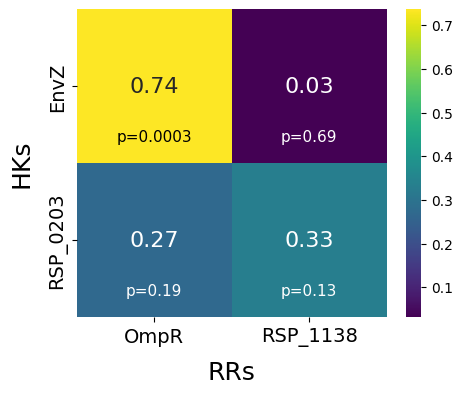

In [116]:
plt.figure(figsize=(5,4))

# Make base similarity heatmap with values
ax = sns.heatmap(
    wet_validation_similarity_matrix,
    annot=True, fmt=".2f", cmap="viridis",
    xticklabels=["OmpR", "RSP_1138"], yticklabels=["EnvZ", "RSP_0203"],
    annot_kws={"fontsize":16}
)

# Annotate p-values manually
p_values = np.array([
    [envz_ompr_p_value_more, envz_rsp_1138_p_value_less],
    [rsp_0203_ompr_p_value_more, rsp_0203_rsp_1138_p_value_less]
])

for (i, j), pval in np.ndenumerate(p_values):
    # Get the background color of the cell from the heatmap
    facecolors = ax.collections[0].get_facecolors()
    idx = i * p_values.shape[1] + j  # Flattened index for quad mesh
    rgb = facecolors[idx][:3]
    # Calculate relative luminance (Y) for sRGB
    luminance = 0.2126*rgb[0] + 0.7152*rgb[1] + 0.0722*rgb[2]
    text_color = 'black' if luminance > 0.5 else 'white'
    # Offset annotation below number, smaller font
    text = f'p={pval:.2}'
    ax.text(j+0.5, i+0.78, text, color=text_color, ha='center', va='top', fontsize=11, fontweight='normal')

plt.xlabel("RRs", fontsize=18, labelpad=10)
plt.xticks(fontsize=14)
plt.ylabel("HKs", fontsize=18, labelpad=10)
plt.yticks(fontsize=14)

plt.savefig("Wet_Validation_Similarity_Matrix.png", dpi=300, bbox_inches="tight")

plt.show()

### Visualize shared embedding space

#### HK vs RR embeddings

##### Before

In [150]:
# Prepare data for t-SNE
# Combine HK and RR embeddings
all_embeddings_before = np.concatenate([
    np.array(test_df['hk_embedding'].tolist()),
    np.array(test_df['rr_embedding'].tolist())
], axis=0)

# Create labels (0 for HK, 1 for RR)
labels = np.array([0] * len(test_df) + [1] * len(test_df))

# Perform t-SNE
# Reduce perplexity and max_iter for faster computation on potentially large datasets
tsne_before = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results_before = tsne_before.fit_transform(all_embeddings_before)

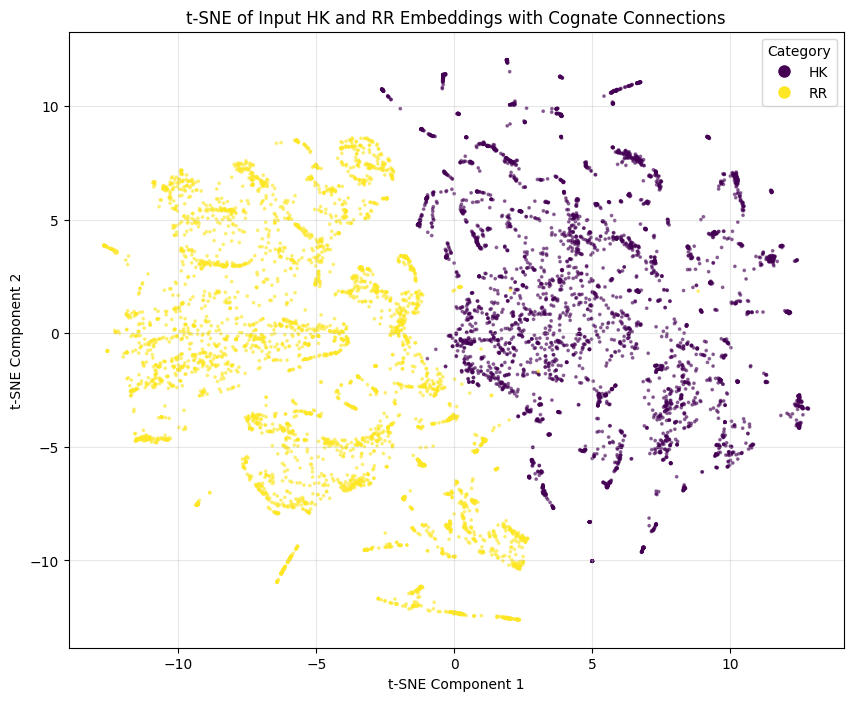

In [151]:
# Plot results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results_before[:, 0], tsne_results_before[:, 1], c=labels, cmap='viridis', alpha=0.5, s=3)

# Add lines connecting cognate HK and RR pairs
# Assuming the first half of tsne_results are HKs and the second half are RRs,
# and that the order corresponds to cognate pairs (HK at index i is cognate to RR at index i + len(test_df))
num_pairs = len(test_df)
for i in range(num_pairs):
    hk_coords = tsne_results_before[i]
    rr_coords = tsne_results_before[i + num_pairs]
    # plt.plot([hk_coords[0], rr_coords[0]], [hk_coords[1], rr_coords[1]], 'k-', linewidth=0.5, alpha=0.2) # Black thin line

# Add legend
legend_labels = ['HK', 'RR']
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                      markerfacecolor=scatter.get_cmap()(scatter.norm(i)), markersize=10)
           for i, label in enumerate(legend_labels)]
plt.legend(handles=handles, title="Category")

plt.title('t-SNE of Input HK and RR Embeddings with Cognate Connections')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.show()

##### After

In [67]:
# Prepare data for t-SNE
# Combine HK and RR embeddings
all_embeddings = np.concatenate([
    np.array(eval_df['hk_predicted_embedding'].tolist()),
    np.array(eval_df['rr_predicted_embedding'].tolist())
], axis=0)

# Create labels (0 for HK, 1 for RR)
labels = np.array([0] * len(eval_df) + [1] * len(eval_df))

# Perform t-SNE
# Reduce perplexity and max_iter for faster computation on potentially large datasets
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results = tsne.fit_transform(all_embeddings)

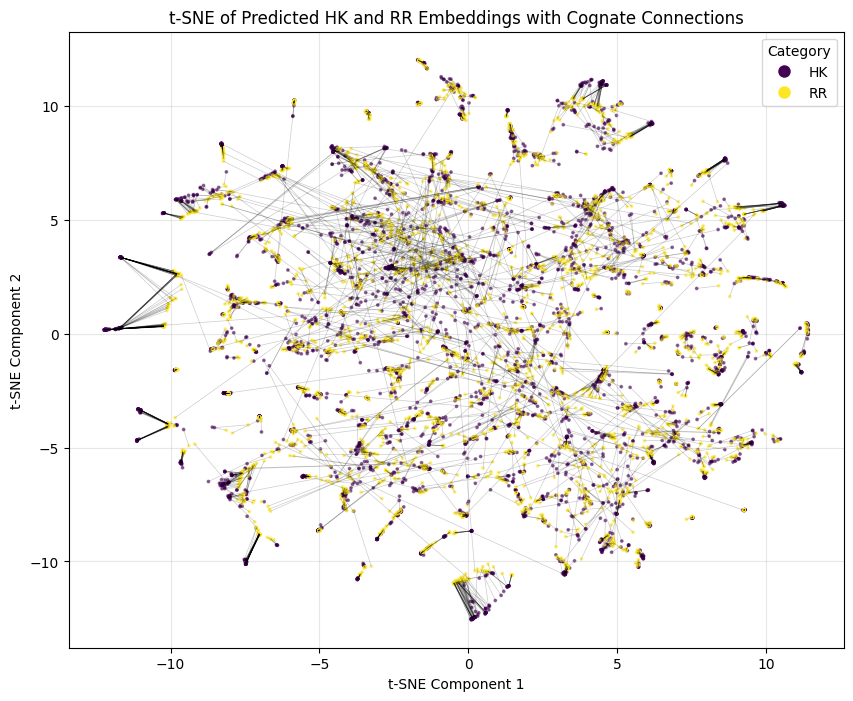

In [68]:
# Plot results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.5, s=3)

# Add lines connecting cognate HK and RR pairs
# Assuming the first half of tsne_results are HKs and the second half are RRs,
# and that the order corresponds to cognate pairs (HK at index i is cognate to RR at index i + len(eval_df))
num_pairs = len(eval_df)
for i in range(num_pairs):
    hk_coords = tsne_results[i]
    rr_coords = tsne_results[i + num_pairs]
    plt.plot([hk_coords[0], rr_coords[0]], [hk_coords[1], rr_coords[1]], 'k-', linewidth=0.5, alpha=0.2) # Black thin line

# Add legend
legend_labels = ['HK', 'RR']
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                      markerfacecolor=scatter.get_cmap()(scatter.norm(i)), markersize=10)
           for i, label in enumerate(legend_labels)]
plt.legend(handles=handles, title="Category")

plt.title('t-SNE of Predicted HK and RR Embeddings with Cognate Connections')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.show()

#### HK+RR pair embeddings

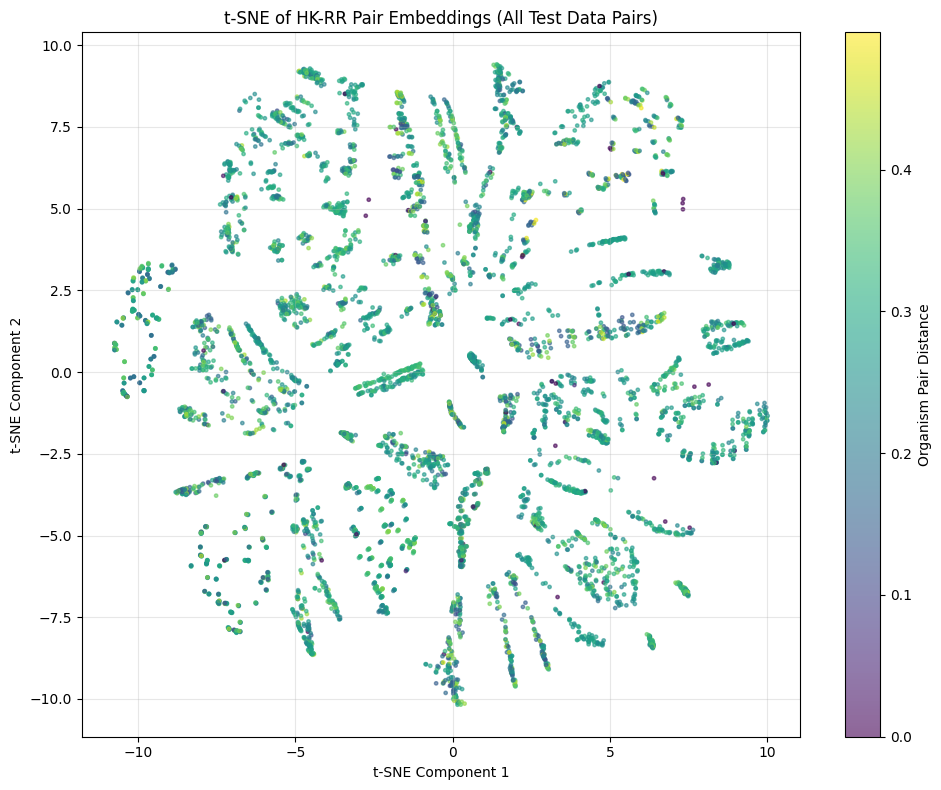

In [82]:
# Assuming eval_df has columns: 'hk_predicted_embedding', 'rr_predicted_embedding', 'organism'
# and there is a distance matrix DataFrame: distance_mat_df with organism names as index and columns

# Parameters for sampling and pairing
num_hk_samples = 100   # number of HKs to sample
num_rr_samples = 100   # number of RRs to sample

# Sample random HKs and RRs with their organism names
hk_samples = eval_df.sample(n=num_hk_samples, random_state=42)
rr_samples = eval_df.sample(n=num_rr_samples, random_state=43)

# Get embeddings and corresponding organism names
# Each row provides: hk_embedding, hk_organism, rr_embedding, rr_organism
hk_emb_list = hk_samples['hk_predicted_embedding'].tolist()
hk_org_list = hk_samples['organism'].tolist()
hk_gene_list = hk_samples['hk_gene'].tolist() if 'hk_gene' in hk_samples.columns else [""]*num_hk_samples

rr_emb_list = rr_samples['rr_predicted_embedding'].tolist()
rr_org_list = rr_samples['organism'].tolist()
rr_gene_list = rr_samples['rr_gene'].tolist() if 'rr_gene' in rr_samples.columns else [""]*num_rr_samples

# Form all possible pairs: (i, j) - hk i with rr j
all_pairs = []
all_distances = []
all_pair_labels = []
for i, (hk_emb, hk_org, hk_gene) in enumerate(zip(hk_emb_list, hk_org_list, hk_gene_list)):
    for j, (rr_emb, rr_org, rr_gene) in enumerate(zip(rr_emb_list, rr_org_list, rr_gene_list)):
        pair_emb = np.concatenate([hk_emb, rr_emb])
        all_pairs.append(pair_emb)
        # Use distance_mat_df to lookup distance between hk_org and rr_org
        try:
            if hk_org == rr_org:
                dist = 0.0
            else:
                dist = distance_mat_df.loc[hk_org, rr_org]
        except Exception:
            dist = np.nan
        all_distances.append(dist)
        all_pair_labels.append(f'HK:{hk_org} ({hk_gene}) | RR:{rr_org} ({rr_gene})')

# Convert to numpy arrays
all_pairs_np = np.vstack(all_pairs)
all_distances_np = np.array(all_distances)

# tSNE
tsne_pairs = TSNE(n_components=2, random_state=123, perplexity=30, max_iter=300)
tsne_pair_results = tsne_pairs.fit_transform(all_pairs_np)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    tsne_pair_results[:, 0], tsne_pair_results[:, 1],
    c=all_distances_np, cmap='viridis', alpha=0.6, s=6
)
cbar = plt.colorbar(scatter)
cbar.set_label('Organism Pair Distance')
plt.title('t-SNE of HK-RR Pair Embeddings (All Test Data Pairs)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
